In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import seaborn as sns
import cv2
import os
import glob
import statistics
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

# from sklearnex import patch_sklearn
# patch_sklearn()

# from sklearn.externals import joblib
import pickle

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
track_data = pd.read_csv('track_data_final_top_genre.csv')
# track_data = pd.read_csv('track_data_1990_2020.csv')
track_data = track_data.loc[track_data.year >= 1970]
# track_data.loc[track_data.year>=1990].to_csv('track_data_2000_2020.csv', index=False)
# track_data.loc[track_data.year>=1990].info()

In [4]:
track_data.isnull().sum()
track_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101201 entries, 8431 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                101201 non-null  object 
 1   song              101201 non-null  object 
 2   artists           101201 non-null  object 
 3   genres            101201 non-null  object 
 4   year              101201 non-null  int64  
 5   duration_ms       101201 non-null  int64  
 6   explicit          101201 non-null  int64  
 7   popularity        101201 non-null  int64  
 8   danceability      101201 non-null  float64
 9   energy            101201 non-null  float64
 10  key               101201 non-null  int64  
 11  loudness          101201 non-null  float64
 12  mode              101201 non-null  int64  
 13  speechiness       101201 non-null  float64
 14  acousticness      101201 non-null  float64
 15  instrumentalness  101201 non-null  float64
 16  liveness          1012

In [5]:
track_data.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
8431,5DnT9a5IM3eMjKgXTWVJvi,Have You Ever Seen The Rain,Creedence Clearwater Revival,swamp rock,1970,160333,0,71,0.743,0.470,0,13.154,1,0.0290,0.0936,0.000031,0.1860,0.890,116.122
8432,2eF8pWbiivYsYRpbntYsnc,"Signed, Sealed, Delivered (I'm Yours)",Stevie Wonder,quiet storm,1970,161160,0,77,0.675,0.597,5,11.329,1,0.0337,0.0534,0.000000,0.0986,0.828,108.875
8433,2QpN1ZVw8eJO5f7WcvUA1k,Santa Claus Is Coming To Town,The Jackson 5,soul,1970,144013,0,75,0.692,0.762,0,4.867,1,0.0342,0.4240,0.000013,0.1810,0.961,146.673
8434,3lh3iiiJeiBXHSZw6u0kh6,Into the Mystic - 2013 Remaster,Van Morrison,rock,1970,205613,0,74,0.608,0.524,8,10.266,1,0.0309,0.3670,0.002540,0.1150,0.797,86.204
8435,1oht5GevPN9t1T3kG1m1GO,Fire and Rain - 2019 Remaster,James Taylor,rock,1970,203613,0,74,0.597,0.271,5,17.293,1,0.0394,0.7660,0.011900,0.0933,0.338,76.271


In [6]:
track_data.shape

(101201, 19)

# Checking for numerical columns

In [7]:
track_data.select_dtypes(np.number)

,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
8431,1970,160333,0,71,0.7430,0.47000,0,13.154,1,0.0290,0.093600,0.000031,0.1860,0.8900,116.122
8432,1970,161160,0,77,0.6750,0.59700,5,11.329,1,0.0337,0.053400,0.000000,0.0986,0.8280,108.875
8433,1970,144013,0,75,0.6920,0.76200,0,4.867,1,0.0342,0.424000,0.000013,0.1810,0.9610,146.673
8434,1970,205613,0,74,0.6080,0.52400,8,10.266,1,0.0309,0.367000,0.002540,0.1150,0.7970,86.204
8435,1970,203613,0,74,0.5970,0.27100,5,17.293,1,0.0394,0.766000,0.011900,0.0933,0.3380,76.271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,2019,196875,0,59,0.7660,0.64900,1,13.051,1,0.0958,0.000755,0.545000,0.1370,0.4940,127.996
170649,2020,84528,1,62,0.7140,0.38800,2,13.020,0,0.5350,0.915000,0.000000,0.0722,0.1810,135.171
170650,2020,187246,1,65,0.8200,0.55500,0,7.114,1,0.1520,0.348000,0.000000,0.1210,0.5540,103.039
170651,2020,170000,0,68,0.0788,0.71000,5,22.824,1,0.0921,0.042600,0.702000,0.3750,0.0065,84.750


# Correlation matrix - Heat Map

In [8]:
visual_data = track_data.drop(columns=['song', 'artists', 'id', 'genres'], axis=1).drop_duplicates(keep='last')

Top 25 Selected Features Against popularity :
year                0.613612
explicit            0.245861
danceability        0.153216
speechiness         0.091129
energy              0.085411
key                 0.005256
tempo              -0.000785
mode               -0.061087
valence            -0.071240
liveness           -0.080916
duration_ms        -0.093970
acousticness       -0.098556
instrumentalness   -0.134881
loudness           -0.262674
Name: popularity, dtype: float64



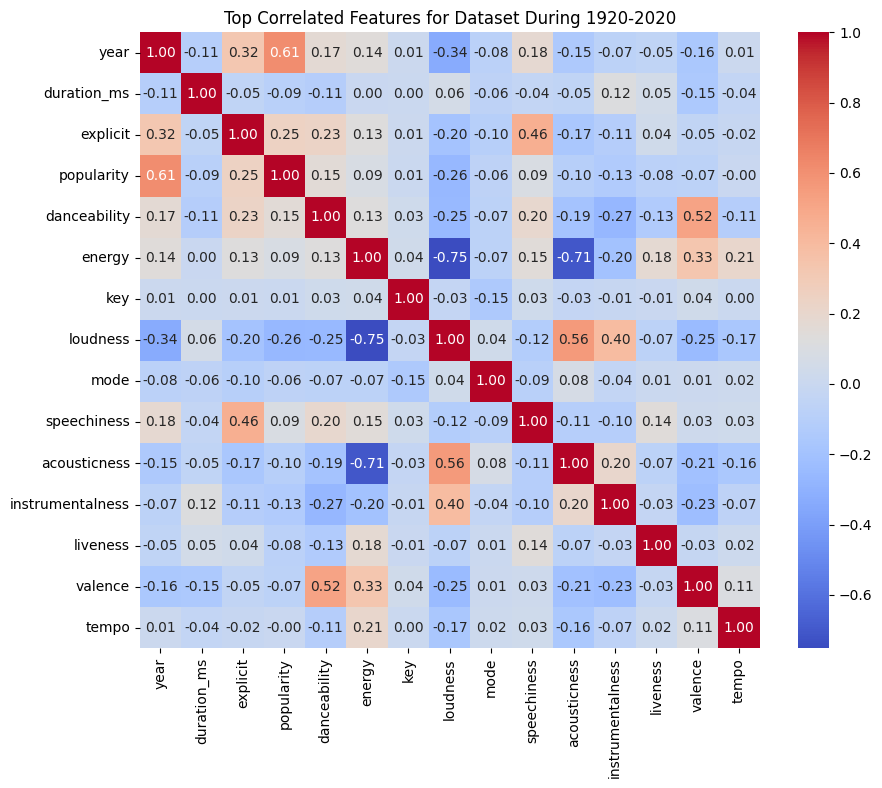

In [9]:
def selectfeatures_correlation(df, num_features=5, target_feature=None, threshold = 0.5, stage= None, cmap='coolwarm'):
    correlation_matrix_draft = df.corr()
    top_corr_features = correlation_matrix_draft.index[abs(correlation_matrix_draft[target_feature]) > threshold]
    correlation_matrix = df[top_corr_features].corr()
    features_list = correlation_matrix[target_feature].sort_values(ascending=False)
    print(f'Top {num_features} Selected Features Against {target_feature} :\n{features_list[1:num_features+1]}\n')
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=cmap)
    plt.title(f'Top Correlated Features for Dataset {stage}')
    plt.show()

    return correlation_matrix, features_list

correlation_matrix, features_list = selectfeatures_correlation(visual_data,num_features=25, target_feature='popularity', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

Top 25 Selected Features Against acousticness :
loudness            0.556888
instrumentalness    0.199916
mode                0.076002
key                -0.028407
duration_ms        -0.050854
liveness           -0.067683
popularity         -0.098556
speechiness        -0.106970
year               -0.146629
tempo              -0.158420
explicit           -0.167802
danceability       -0.192981
valence            -0.210183
energy             -0.707858
Name: acousticness, dtype: float64



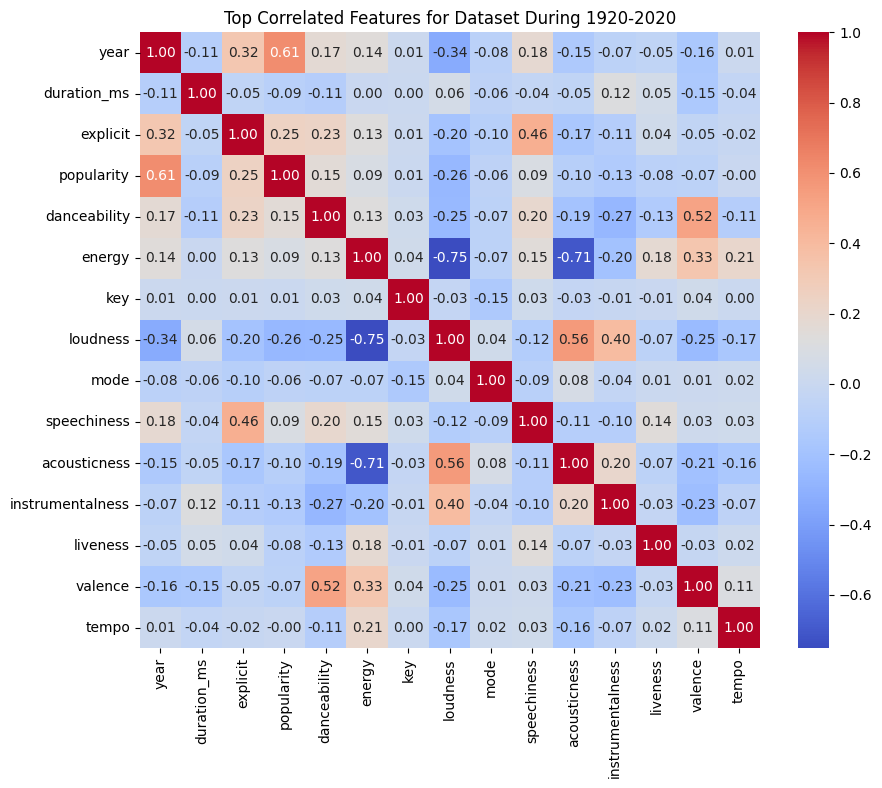

In [10]:
correlation_matrix, features_list = selectfeatures_correlation(visual_data,num_features=25, target_feature='acousticness', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

Top 25 Selected Features Against danceability :
valence             0.519722
explicit            0.228391
speechiness         0.195330
year                0.167188
popularity          0.153216
energy              0.129517
key                 0.030022
mode               -0.068447
tempo              -0.109880
duration_ms        -0.110994
liveness           -0.130545
acousticness       -0.192981
loudness           -0.253619
instrumentalness   -0.272335
Name: danceability, dtype: float64



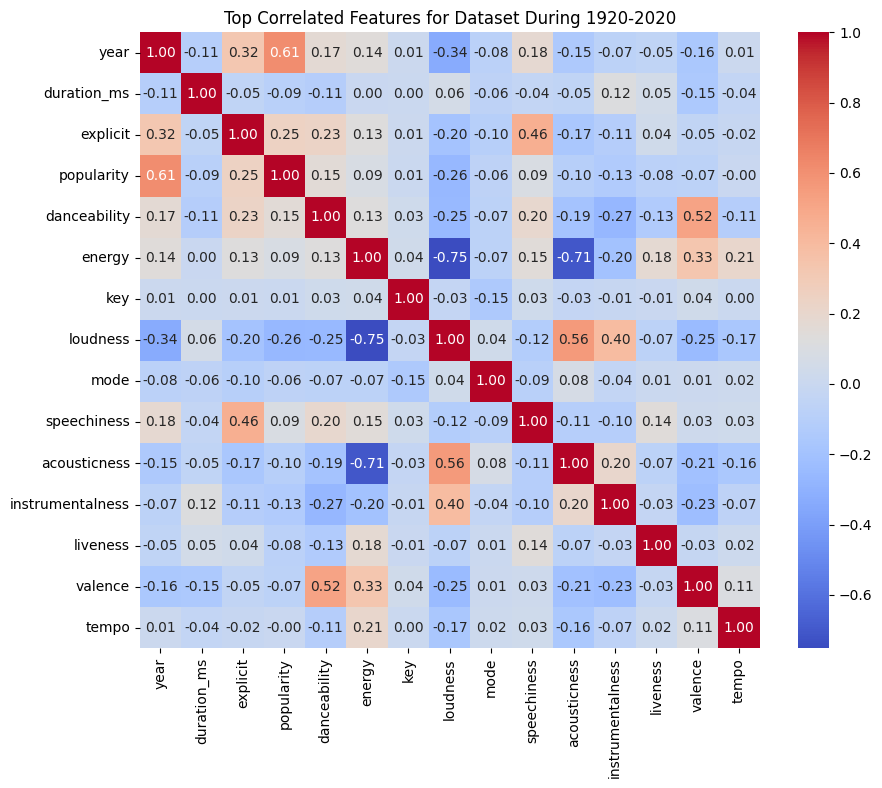

In [11]:
correlation_matrix, features_list = selectfeatures_correlation(visual_data,num_features=25, target_feature='danceability', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

Top 25 Selected Features Against speechiness :
explicit            0.464398
danceability        0.195330
year                0.184299
energy              0.150616
liveness            0.139550
popularity          0.091129
tempo               0.034261
key                 0.031989
valence             0.027199
duration_ms        -0.038304
mode               -0.094251
instrumentalness   -0.104833
acousticness       -0.106970
loudness           -0.118885
Name: speechiness, dtype: float64



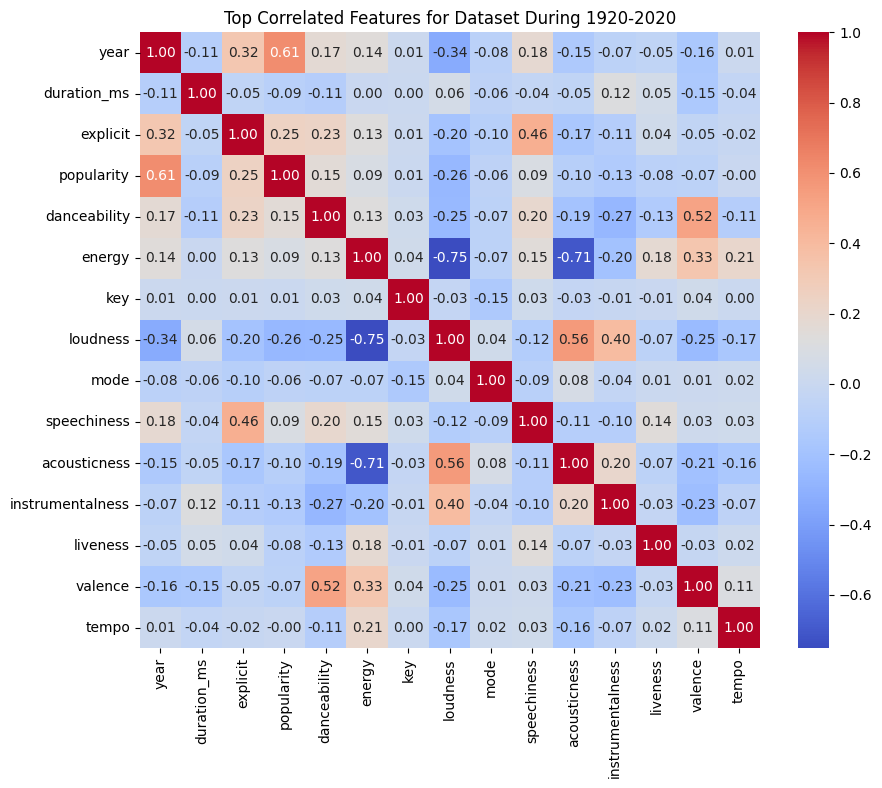

In [12]:
correlation_matrix, features_list = selectfeatures_correlation(visual_data,num_features=25, target_feature='speechiness', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

Top 25 Selected Features Against mode :
acousticness        0.076002
loudness            0.041501
tempo               0.015312
valence             0.007800
liveness            0.005316
instrumentalness   -0.036788
duration_ms        -0.060966
popularity         -0.061087
danceability       -0.068447
energy             -0.069586
year               -0.075443
speechiness        -0.094251
explicit           -0.098873
key                -0.149138
Name: mode, dtype: float64



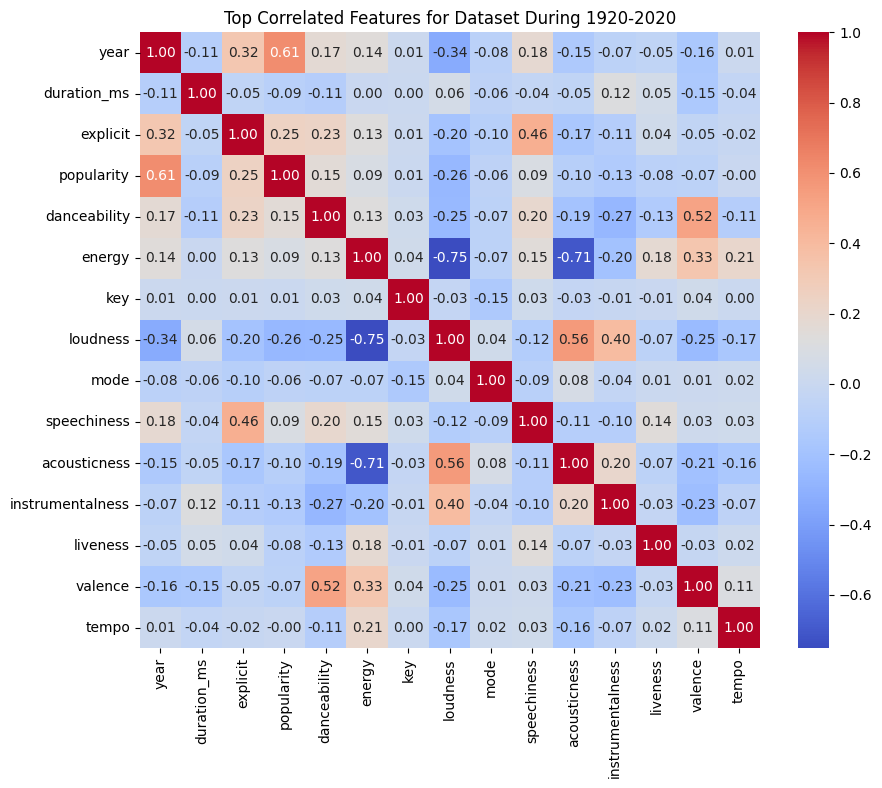

In [13]:
correlation_matrix, features_list = selectfeatures_correlation(visual_data,num_features=25, target_feature='mode', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

**OBSERVATION** 
4 General Correlated groups
1. Popularity, Year, Energy <br>
2. Loudness, acousticness, instrumentalness <br>
3. danceability, valence  <br>
4. speechiness, explicit <br>

In [14]:
visual_data_features = track_data.drop(columns=['song', 'artists', 'id', 'genres', 'duration_ms', 'liveness', 'tempo','key','mode'], axis=1).drop_duplicates(keep='last')

In [15]:
visual_data_features.head()

,year,explicit,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence
8431,1970,0,71,0.743,0.470,13.154,0.0290,0.0936,0.000031,0.890
8432,1970,0,77,0.675,0.597,11.329,0.0337,0.0534,0.000000,0.828
8433,1970,0,75,0.692,0.762,4.867,0.0342,0.4240,0.000013,0.961
8434,1970,0,74,0.608,0.524,10.266,0.0309,0.3670,0.002540,0.797
8435,1970,0,74,0.597,0.271,17.293,0.0394,0.7660,0.011900,0.338


Top 25 Selected Features Against popularity :
year                0.613612
explicit            0.245861
danceability        0.153216
speechiness         0.091129
energy              0.085411
valence            -0.071240
acousticness       -0.098556
instrumentalness   -0.134881
loudness           -0.262674
Name: popularity, dtype: float64



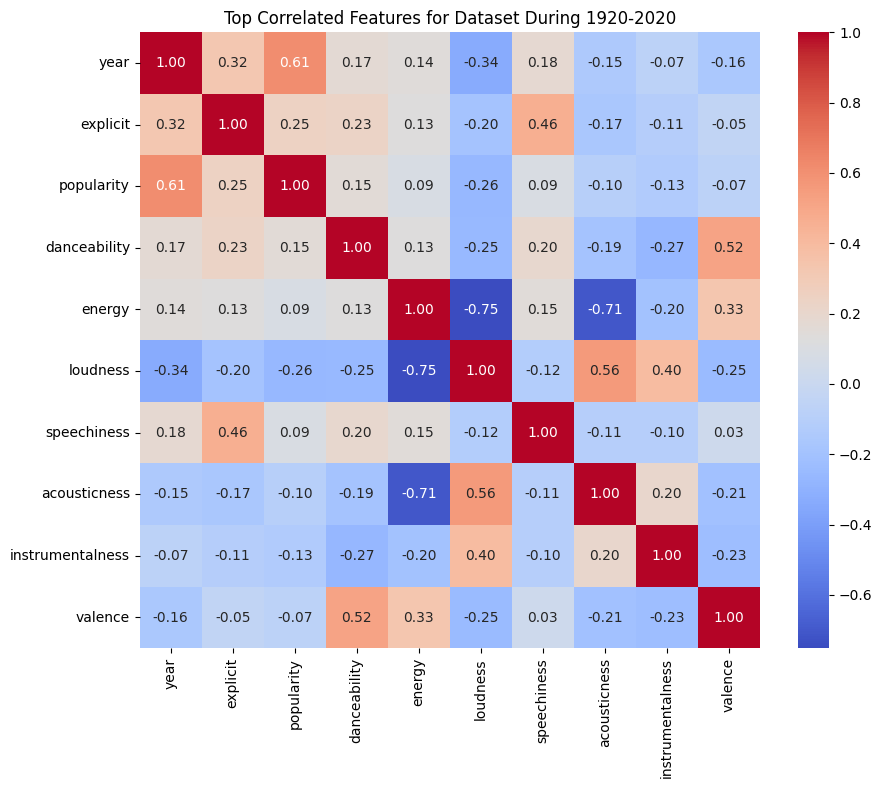

In [16]:
correlation_matrix, features_list = selectfeatures_correlation(visual_data_features,num_features=25, target_feature='popularity', threshold = 0, stage= 'During 1920-2020', cmap='coolwarm')

In [ ]:
track_data_features = track_data_features.drop(columns = ['duration_ms','key','mode','liveness','tempo'])
track_data_features.head()

,id,song,artists,genres,PYE,LAI,DV,SE
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,1925.211,21.956,0.3384,0.0366
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,1925.203,11.585,0.9240,0.0615
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,1923.088,22.611,0.4621,0.0456
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,1921.130,22.655,1.2060,0.0483
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,1921.257,17.397,1.4550,0.3990


In [ ]:

track_data_features = track_data.copy()
track_data_features.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,1921,831667,0,4,0.279,0.211,10,20.096,1,0.0366,0.982,0.878,0.665,0.0594,80.954
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,1921,159507,0,4,0.518,0.203,0,10.589,1,0.0615,0.996,0.000,0.115,0.4060,66.221
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,1921,218773,0,2,0.389,0.088,1,21.091,0,0.0456,0.993,0.527,0.363,0.0731,92.867
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,1921,161520,0,0,0.485,0.130,5,21.508,0,0.0483,0.996,0.151,0.104,0.7210,64.678
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,1921,196560,0,0,0.684,0.257,8,16.415,1,0.3990,0.982,0.000,0.504,0.7710,109.378


**Dropping the less correlated features to verify against the correlation matrix**

In [17]:
visual_data_features = track_data.drop(columns=['song', 'artists', 'id', 'genres', 'duration_ms', 'liveness', 'tempo','key','mode'], axis=1).drop_duplicates(keep='last')

# visualizing trend in music against the years for independent features

100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


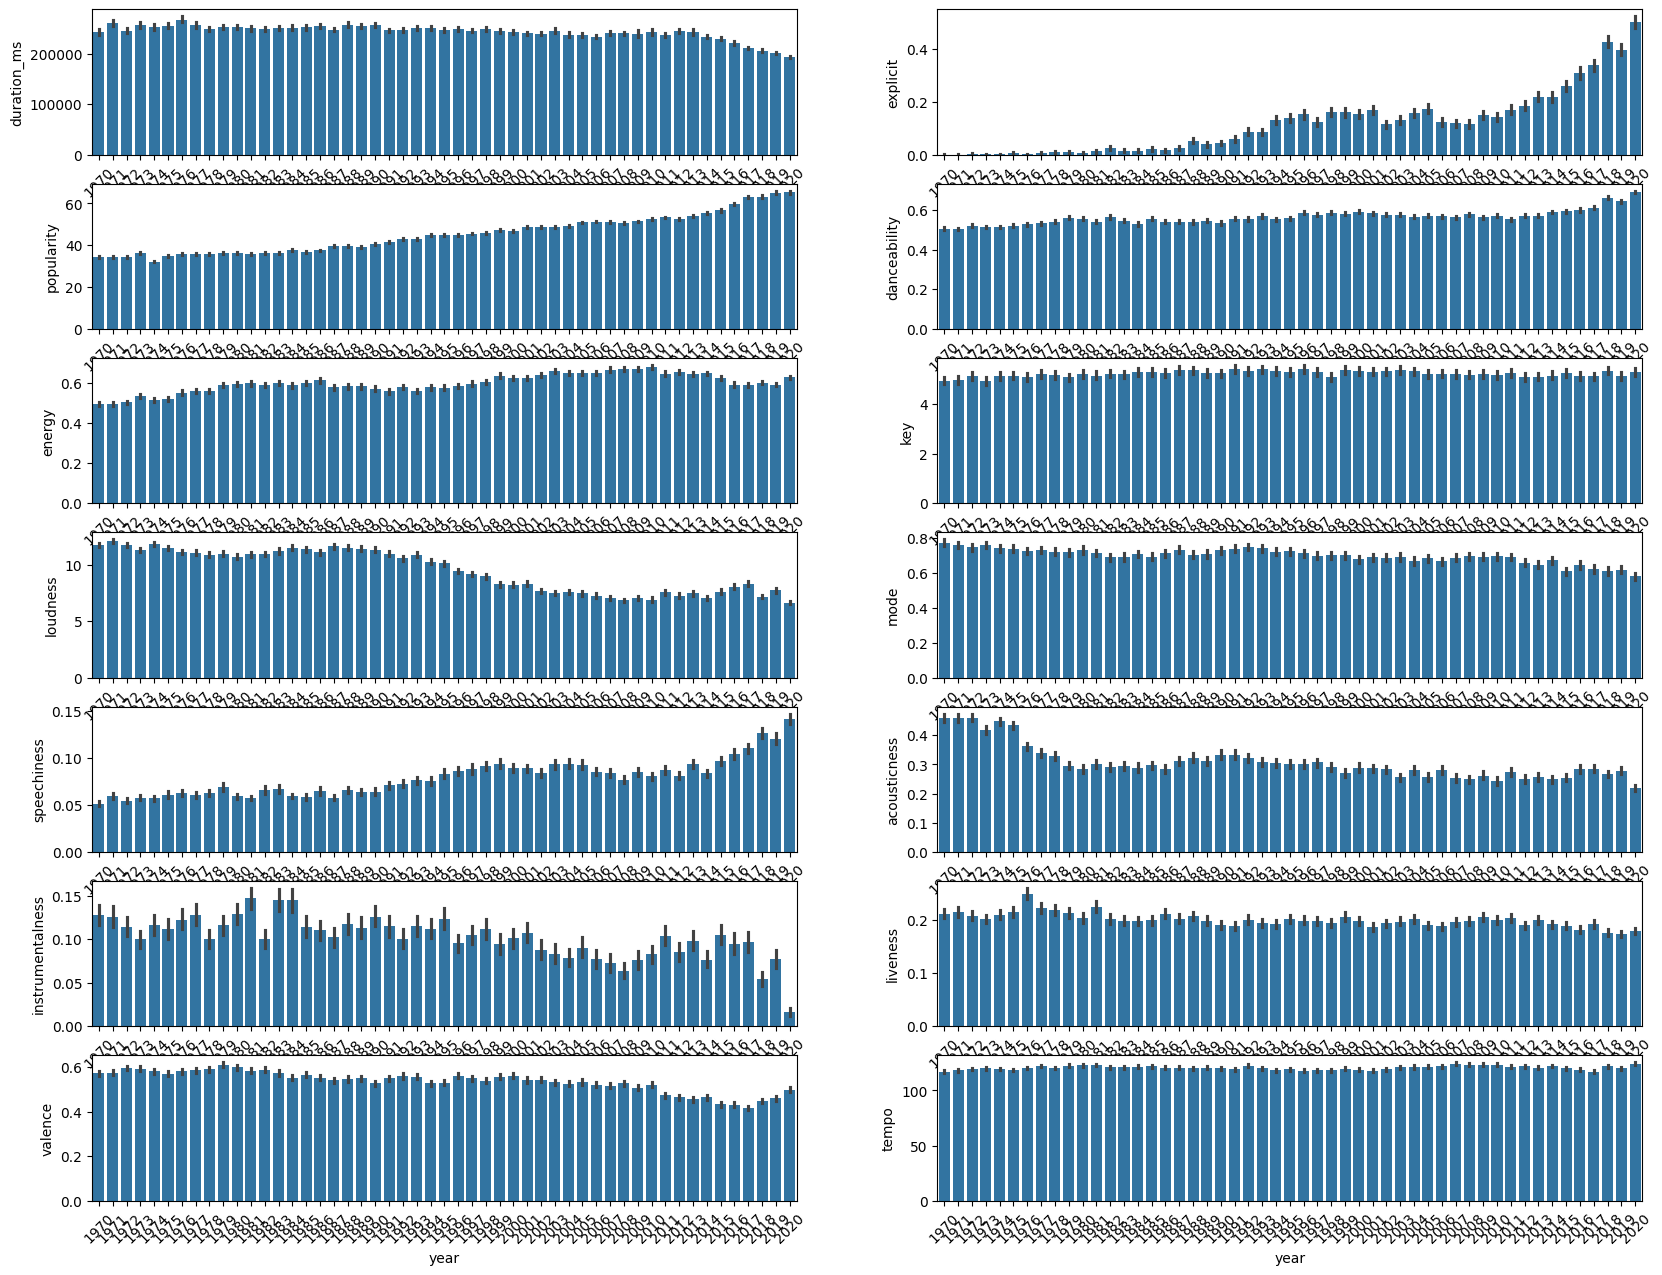

In [18]:
plt.figure(figsize=(20, 20))
for i in tqdm(np.arange(1, len(visual_data.columns))):
    plt.subplot(9, 2, i)
    sns.barplot(x=track_data.year,y=visual_data[visual_data.columns[i]])
    plt.xticks(rotation=45)
plt.show()

# visual_data_features

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


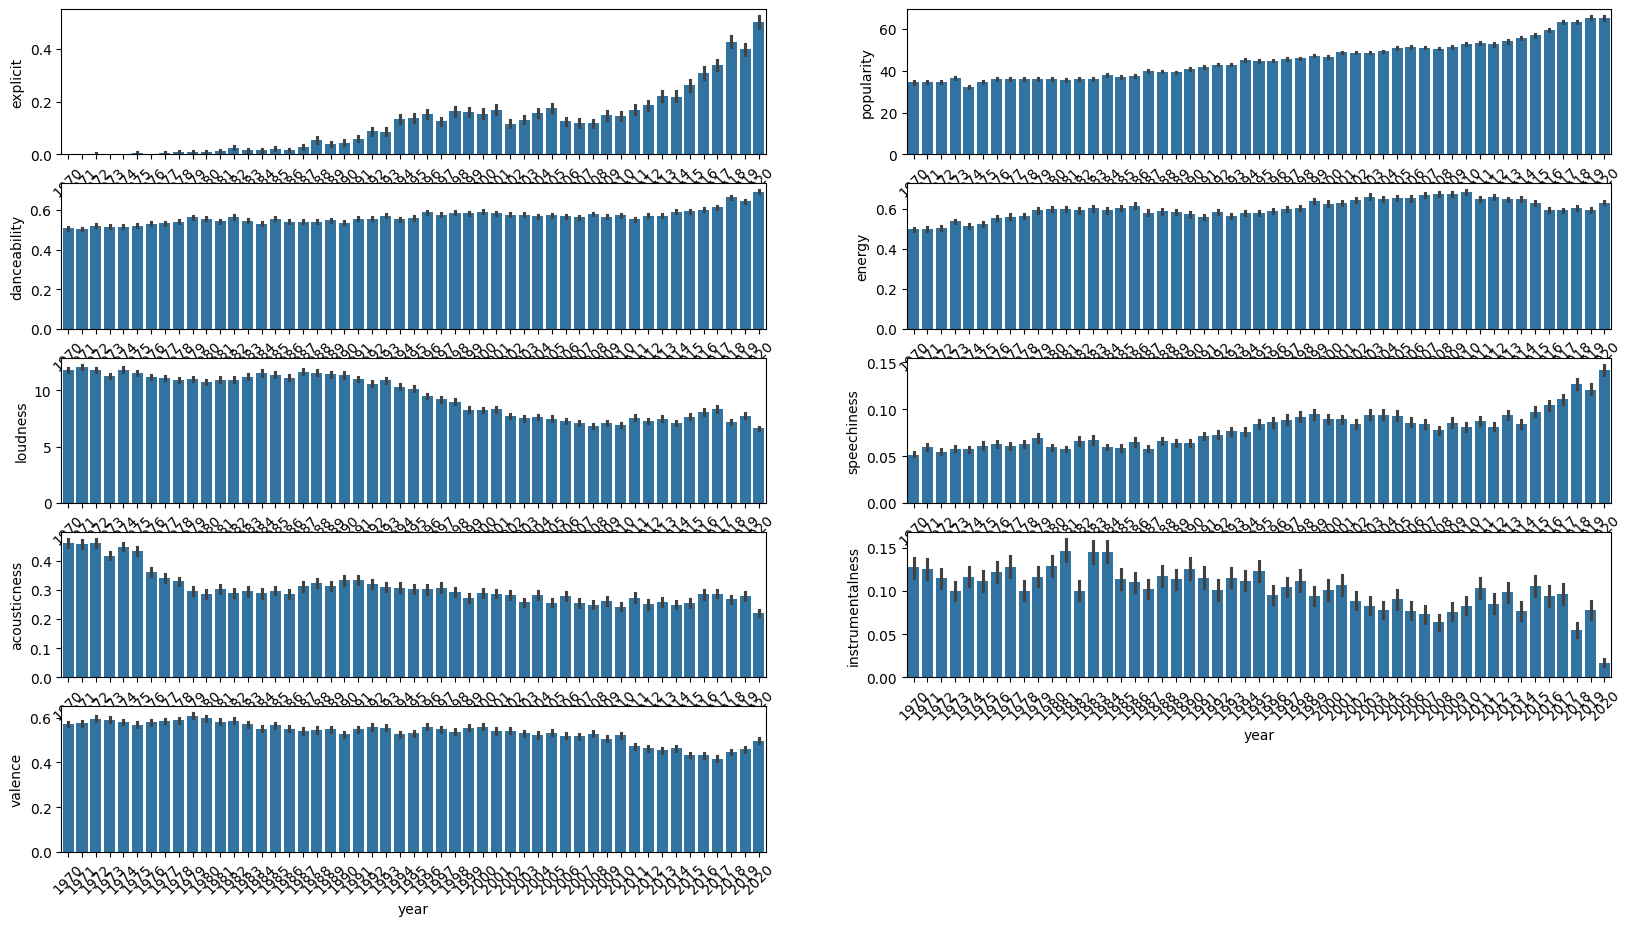

In [19]:
plt.figure(figsize=(20, 20))
for i in tqdm(np.arange(1, len(visual_data_features.columns))):
    plt.subplot(9, 2, i)
    sns.barplot(x=track_data.year,y=visual_data_features[visual_data_features.columns[i]])
    plt.xticks(rotation=45)
plt.show()

**Observation** <br>
The numerical features does not indicate a strong "outlier" challenge. Explicit and Speechiness may seem unbalanced but the diverse values reflects a difference of song structure and its geopolitical nature. Post WW1, WW2 and Post WW2 would have impact the development of music during those times. Seemingly after 1970s, the cultures, trends, internet and geopolitical nature might have affected the music development into less instrumental type of music (linked to loudness and accoustiness) with more explicit nature and energy. More exposure may leads to higher popularity generally.

It is not quite evidential to drop features deem irrelevant with certainty.

# Normalizing the columns & Boxplot visualization to identify outliers

In [20]:
track_data_backup = track_data.copy() 
# track_data_ = track_data_backup.copy()
track_data_minmax = track_data_backup.copy()
track_data_std = track_data_backup.copy()

In [21]:
# minmax_features = track_data_minmax.select_dtypes(np.number).drop(columns = ['year']).columns
minmax_features = track_data_minmax.select_dtypes(np.number).columns
track_data_minmax[minmax_features] = MinMaxScaler().fit_transform(track_data[minmax_features].to_numpy())
track_data_minmax.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
8431,5DnT9a5IM3eMjKgXTWVJvi,Have You Ever Seen The Rain,Creedence Clearwater Revival,swamp rock,0.0,0.027024,0.0,0.71,0.752024,0.470,0.000000,0.219142,1.0,0.030083,0.093976,0.000031,0.1860,0.890,0.476873
8432,2eF8pWbiivYsYRpbntYsnc,"Signed, Sealed, Delivered (I'm Yours)",Stevie Wonder,quiet storm,0.0,0.027177,0.0,0.77,0.683198,0.597,0.454545,0.188722,1.0,0.034959,0.053614,0.000000,0.0986,0.828,0.447112
8433,2QpN1ZVw8eJO5f7WcvUA1k,Santa Claus Is Coming To Town,The Jackson 5,soul,0.0,0.023995,0.0,0.75,0.700405,0.762,0.000000,0.081009,1.0,0.035477,0.425703,0.000013,0.1810,0.961,0.602336
8434,3lh3iiiJeiBXHSZw6u0kh6,Into the Mystic - 2013 Remaster,Van Morrison,rock,0.0,0.035426,0.0,0.74,0.615385,0.524,0.727273,0.171003,1.0,0.032054,0.368474,0.002540,0.1150,0.797,0.354010
8435,1oht5GevPN9t1T3kG1m1GO,Fire and Rain - 2019 Remaster,James Taylor,rock,0.0,0.035055,0.0,0.74,0.604251,0.271,0.454545,0.288134,1.0,0.040871,0.769076,0.011900,0.0933,0.338,0.313219


In [22]:
# std_features = track_data_std.select_dtypes(np.number).drop(columns = ['year']).columns
std_features = track_data_std.select_dtypes(np.number).columns
track_data_std[std_features] = StandardScaler().fit_transform(track_data_std[std_features].to_numpy())
track_data_std.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
8431,5DnT9a5IM3eMjKgXTWVJvi,Have You Ever Seen The Rain,Creedence Clearwater Revival,swamp rock,-1.692854,-0.808017,-0.365027,1.817967,1.018854,-0.532038,-1.475308,0.737328,0.655111,-0.542154,-0.684627,-0.409739,-0.079128,1.362536,-0.149564
8432,2eF8pWbiivYsYRpbntYsnc,"Signed, Sealed, Delivered (I'm Yours)",Stevie Wonder,quiet storm,-1.692854,-0.799962,-0.365027,2.240521,0.631116,-0.010002,-0.065777,0.370713,0.655111,-0.491187,-0.813889,-0.409865,-0.568077,1.124116,-0.390944
8433,2QpN1ZVw8eJO5f7WcvUA1k,Santa Claus Is Coming To Town,The Jackson 5,soul,-1.692854,-0.966957,-0.365027,2.099670,0.728051,0.668233,-1.475308,-0.927403,0.655111,-0.485765,0.377768,-0.409814,-0.107100,1.635565,0.868019
8434,3lh3iiiJeiBXHSZw6u0kh6,Into the Mystic - 2013 Remaster,Van Morrison,rock,-1.692854,-0.367035,-0.365027,2.029244,0.249081,-0.310070,0.779942,0.157173,0.655111,-0.521550,0.194486,-0.399677,-0.476329,1.004905,-1.146063
8435,1oht5GevPN9t1T3kG1m1GO,Fire and Rain - 2019 Remaster,James Taylor,rock,-1.692854,-0.386513,-0.365027,2.029244,0.186359,-1.350031,-0.065777,1.568789,0.655111,-0.429376,1.477463,-0.362132,-0.597727,-0.760173,-1.476908


<Axes: >

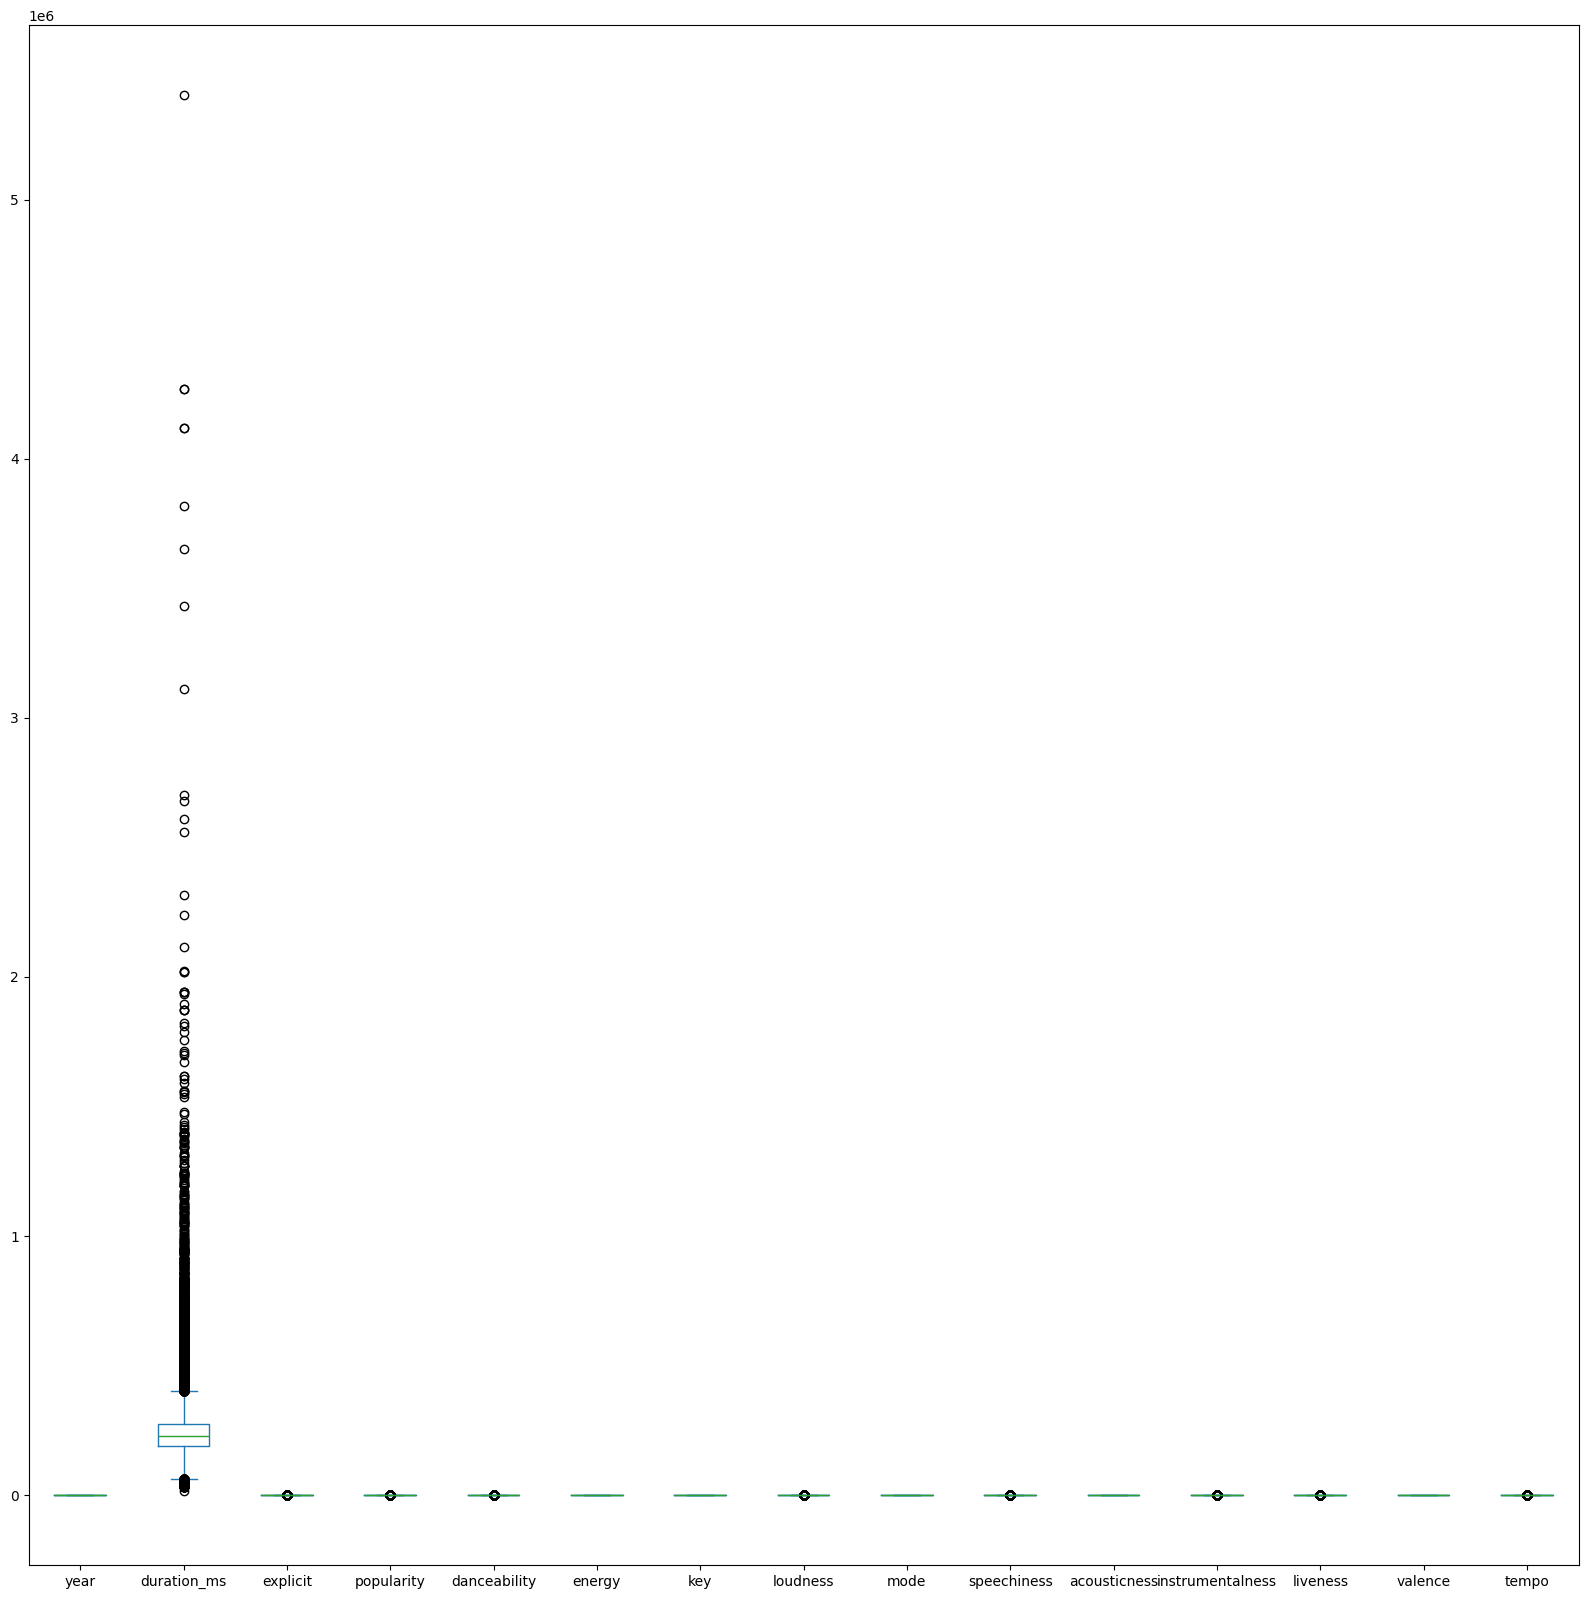

In [23]:
# track_data.select_dtypes(np.number).drop(columns = ['year']).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)
track_data.select_dtypes(np.number).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)

<Axes: >

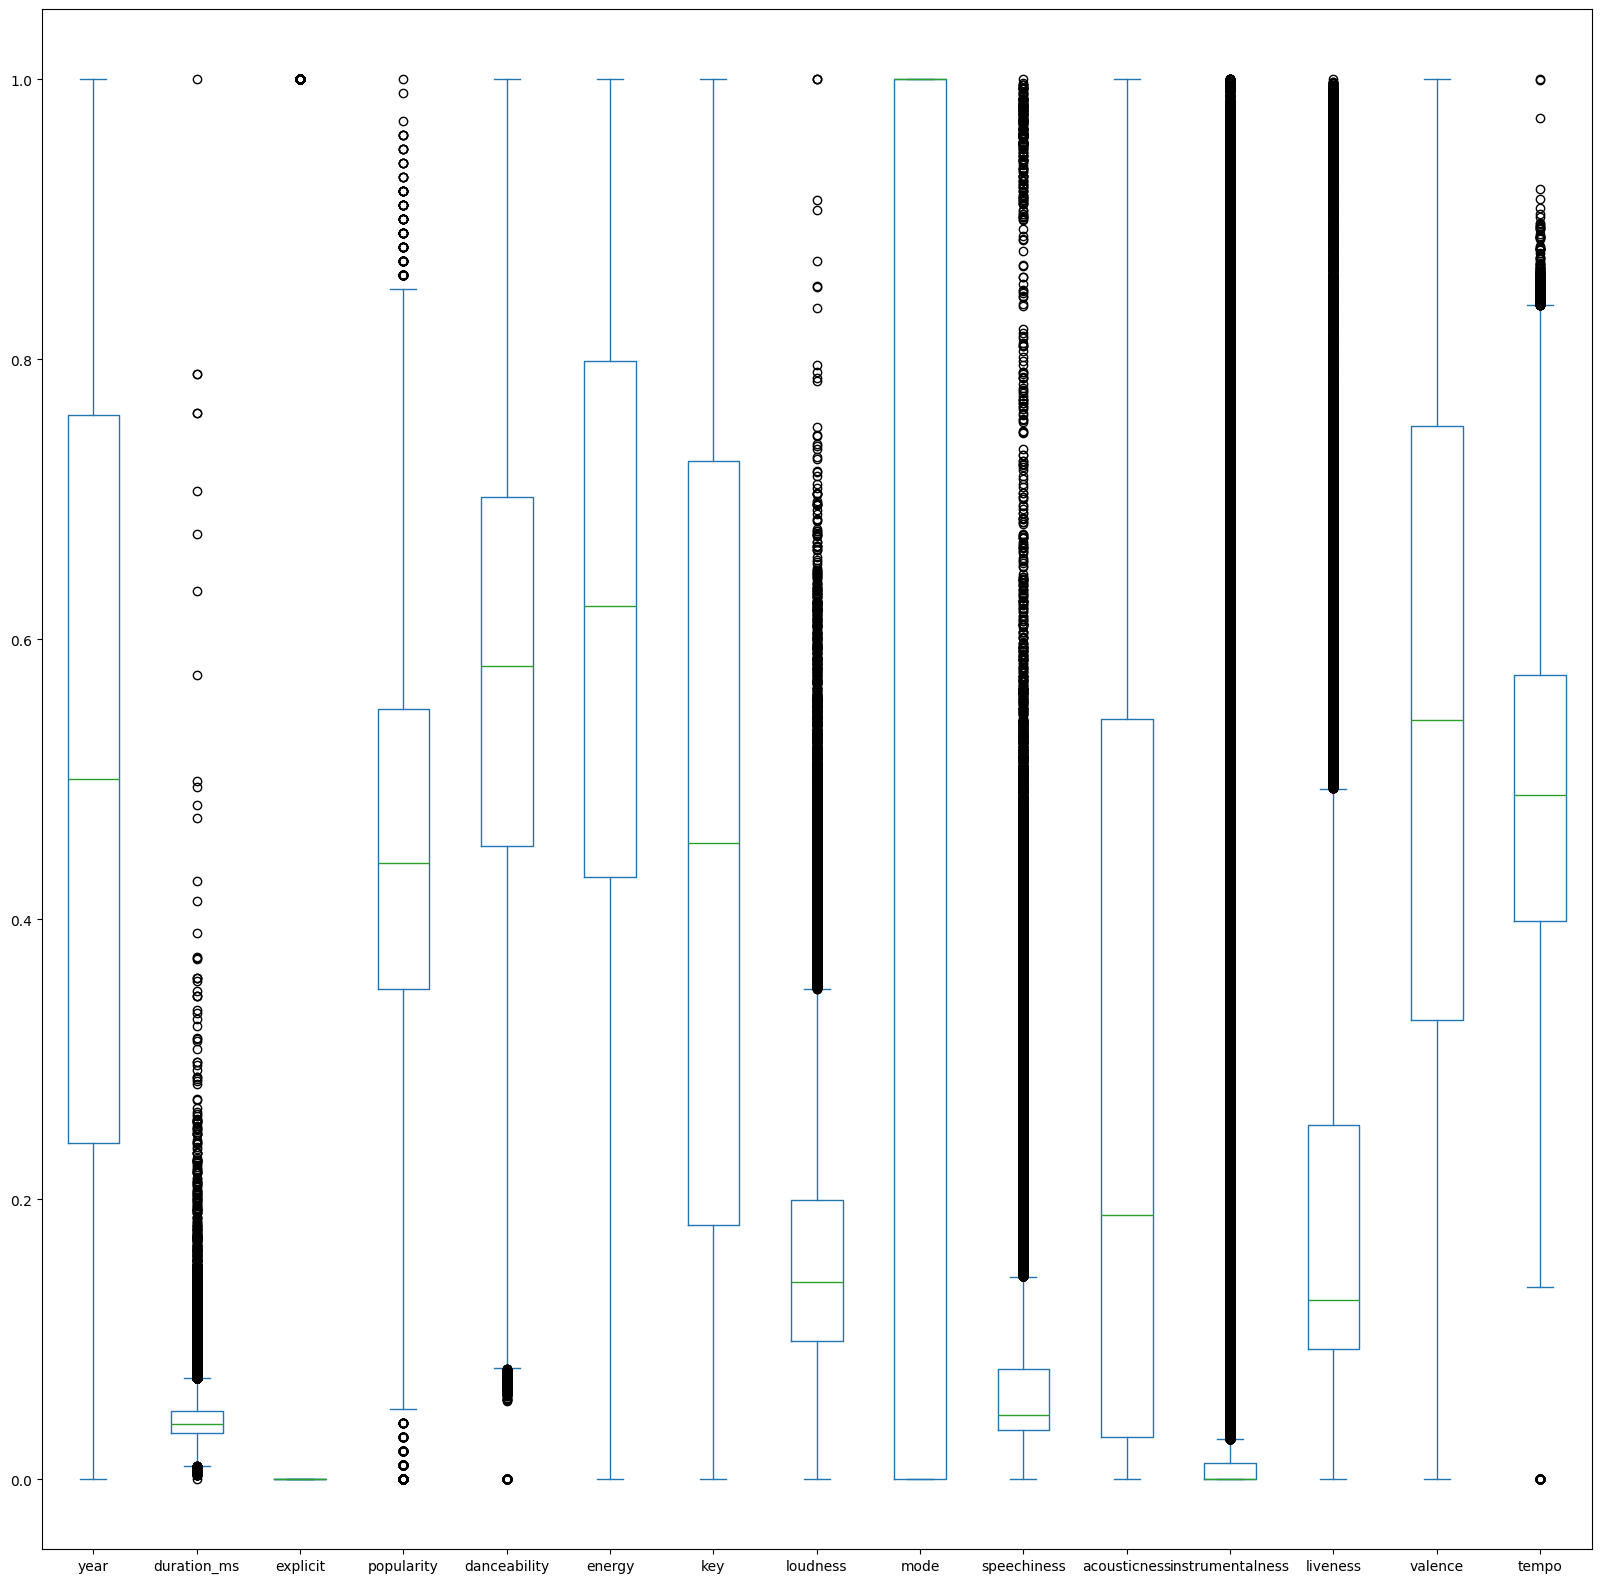

In [24]:
# track_data_minmax.select_dtypes(np.number).drop(columns = ['year']).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)
track_data_minmax.select_dtypes(np.number).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)

<Axes: >

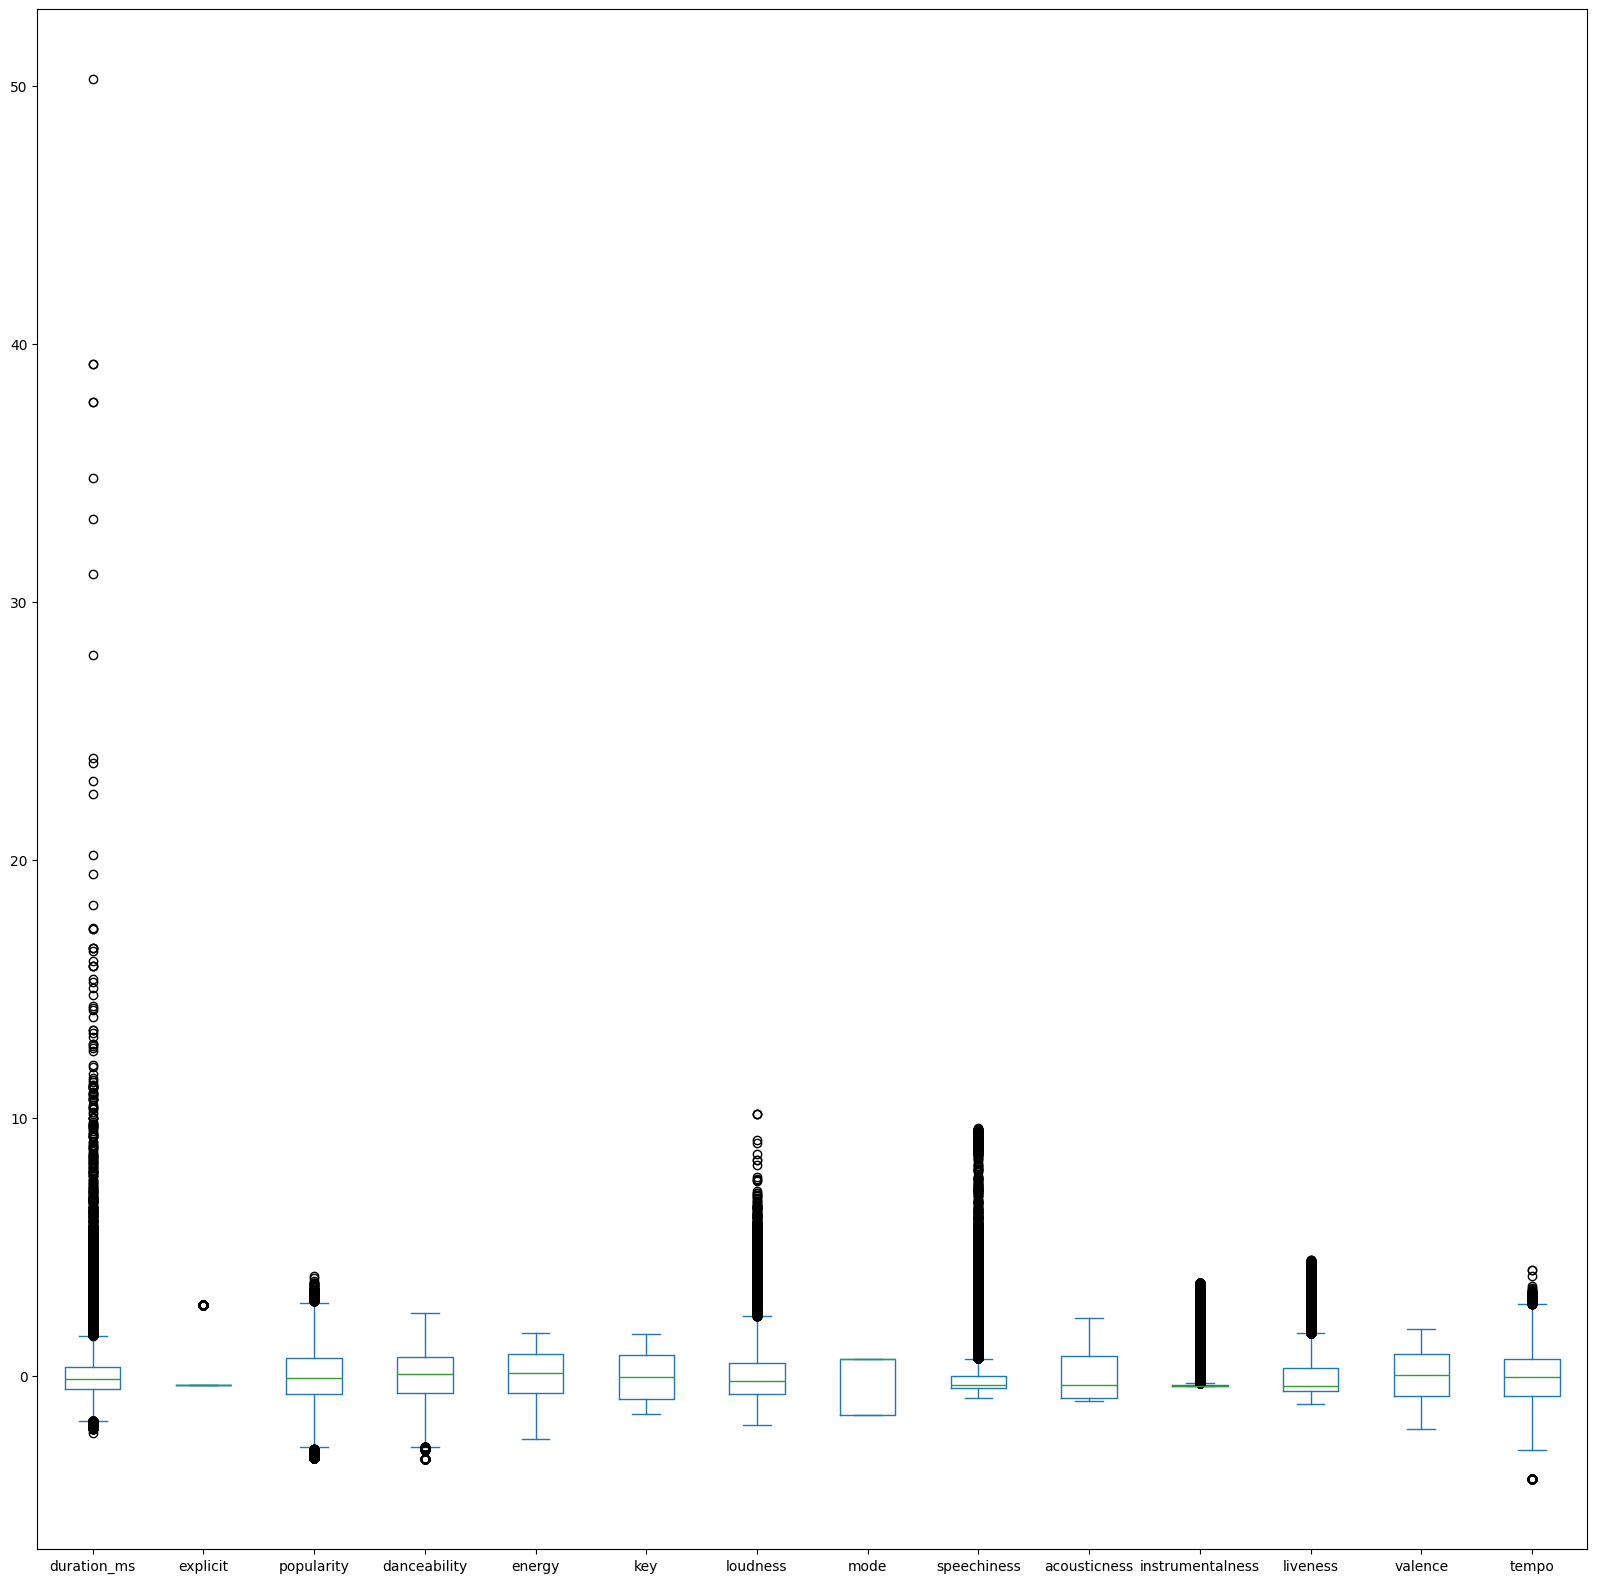

In [25]:
track_data_std.select_dtypes(np.number).drop(columns = ['year']).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)
# track_data.select_dtypes(np.number).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)


**Checking the dropped features** 

<Axes: >

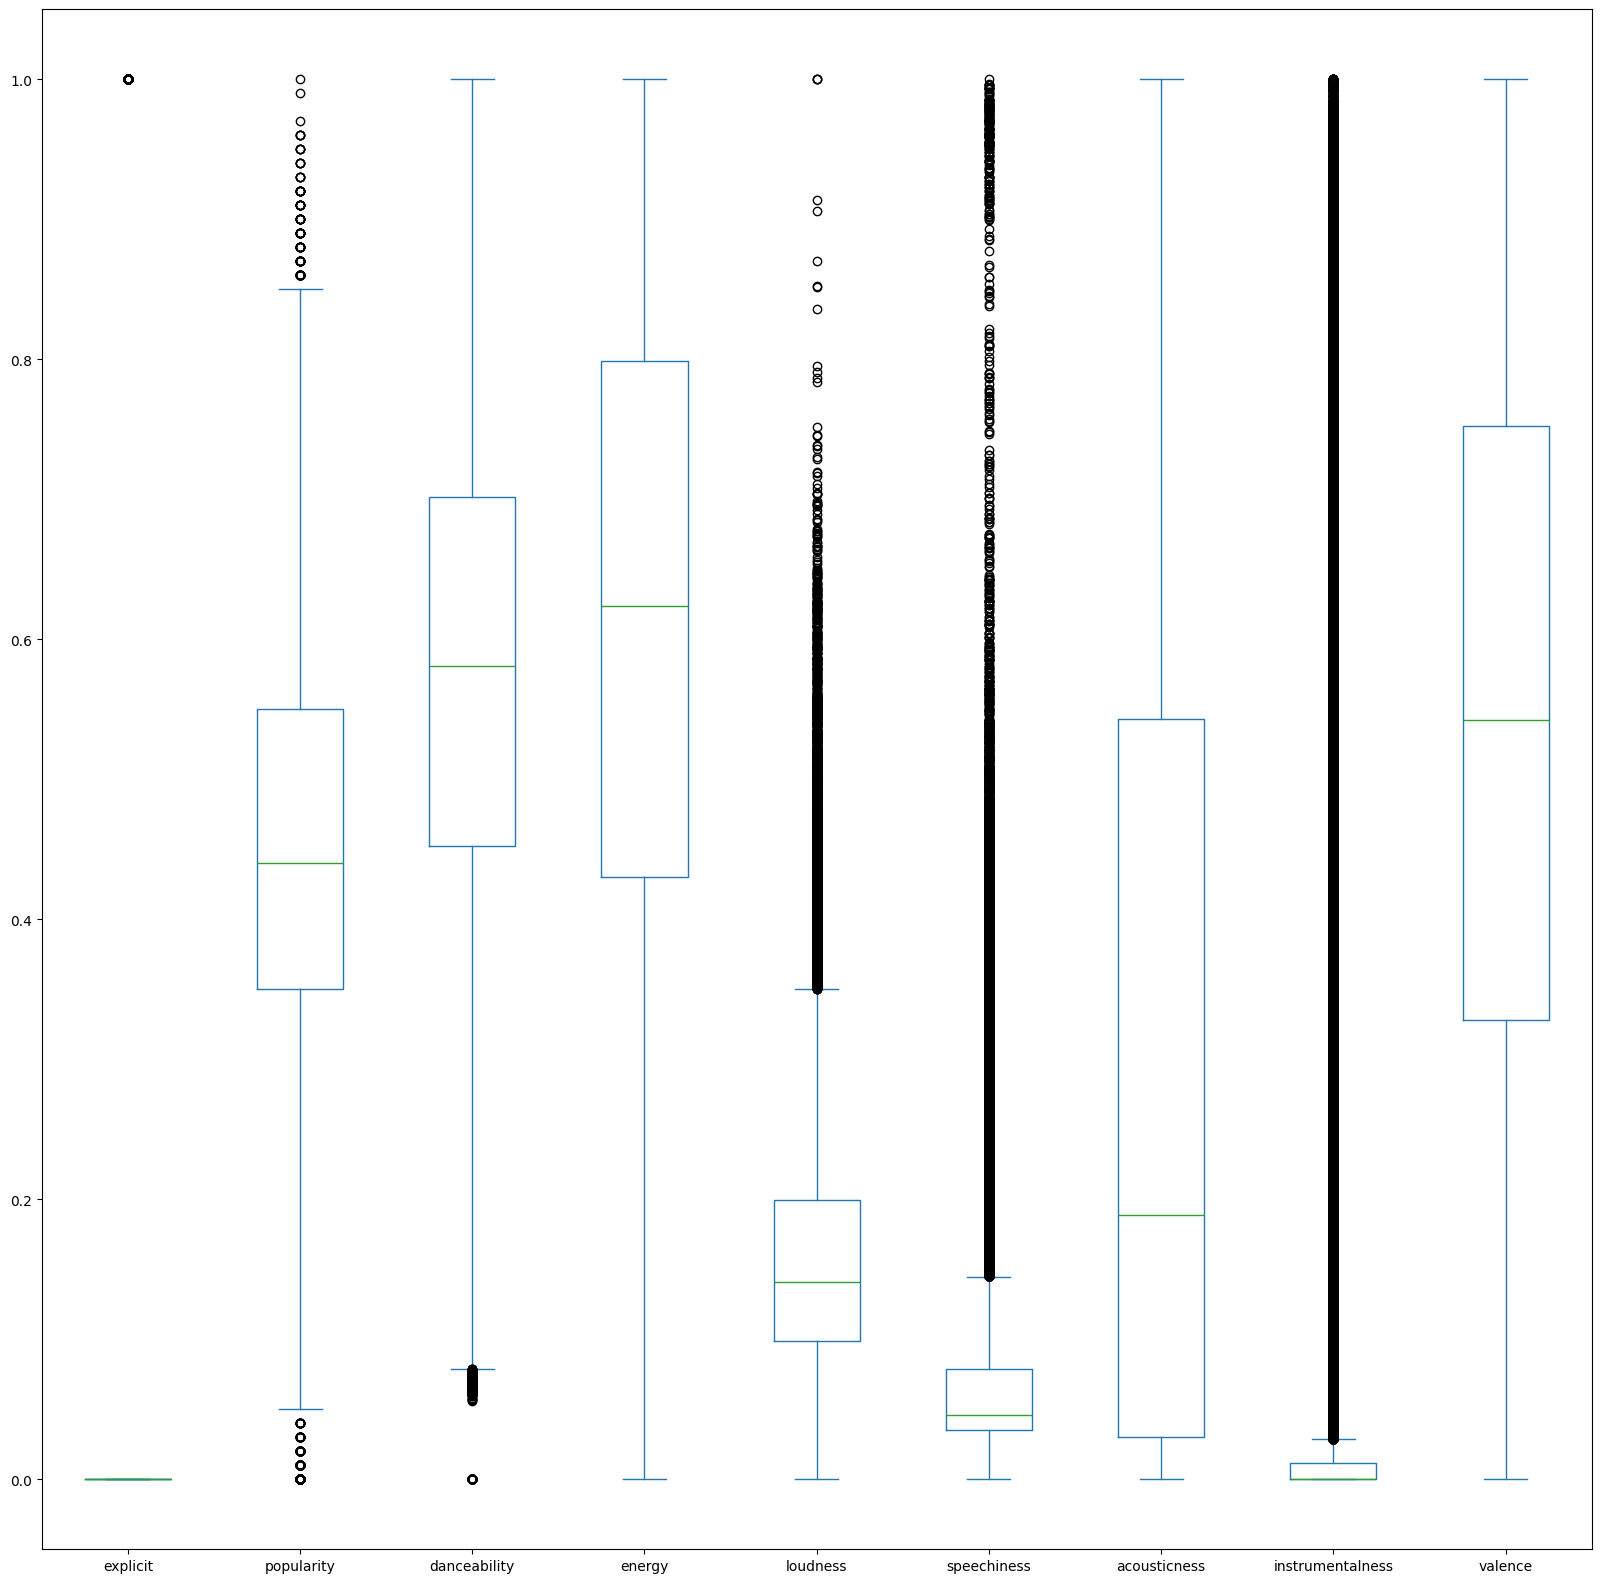

In [26]:
track_data_minmax[visual_data_features.columns].drop(columns = ['year']).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)
# track_data.select_dtypes(np.number).plot(kind='box' ,figsize=(20, 20) ,fontsize=10)

**Observation**<br>
At this juncture => it does not reflect much that the outliers affect the data shape much. For example: duration_ms  will be outlier due to their values even after scaling. But that is because it is in ms. Also while Key, Mode, Tempo, Liveness and Duration_ms had low correlation but these features of a song does reflect a certain song structure and characteristics that can appeal to listeners or users. Loudness, Speechineess, Accoustiness and Instrumentlness might reflect a shifting music preference from 1920-2020. 

Conclusion: It is not conclusive to decide any features importance by looking at data viz. As the data is from from 1920-2020, it would be reflective to include all song features except the year for a balanced view. MinMaxScaler is prehaps the better choice of normalization based on the charts.

In [450]:
track_data_features.head()

,id,song,artists,genres,PYE,LAI,DV,SE,DuKMLT,genres_encoded
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,1925.211,21.956,0.3384,0.0366,831759.619,1670.0
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,1925.203,11.585,0.9240,0.0615,159574.336,1707.0
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,1923.088,22.611,0.4621,0.0456,218867.230,1670.0
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,1921.130,22.655,1.2060,0.0483,161589.782,1576.0
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,1921.257,17.397,1.4550,0.3990,196678.882,1705.0


In [451]:
# minmax_features = track_data_minmax.select_dtypes(np.number).drop(columns = ['year']).columns
COL_CORR_FEATURES = track_data_features.select_dtypes(np.number).columns
track_data_features[COL_CORR_FEATURES] = MinMaxScaler().fit_transform(track_data_features[COL_CORR_FEATURES].to_numpy())
track_data_features.head()

,id,song,artists,genres,PYE,LAI,DV,SE,DuKMLT,genres_encoded
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,0.021034,0.364907,0.171602,0.018579,0.153129,0.938202
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,0.020994,0.191777,0.468560,0.031218,0.028613,0.958989
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,0.010395,0.375841,0.234331,0.023147,0.039597,0.938202
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,0.000584,0.376576,0.611562,0.024518,0.028987,0.885393
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,0.001220,0.288800,0.737830,0.202538,0.035487,0.957865


Essentially, it seems like the outlier is duration_ms. But again, the features seems important at this stage. We should use explore their dimensionals with PCA for a better assessment.

# JOINING THE ENCODED GENRE COLUMNS WITH THE MinMax Dataset with Category

In [38]:
# track_data = pd.read_csv('track_data_final_top_genre.csv')
NUM_FEATURES = track_data.select_dtypes(np.number).columns
CAT_FEATURES = track_data.select_dtypes(object).columns
COUNT_NUM_FEATURES = len(track_data.select_dtypes(np.number).columns)
COUNT_CAT_FEATURES = len(track_data.select_dtypes(object).columns)
# NUM_FEATURES_NOYEAR = track_data.select_dtypes(np.number).drop(columns = ['year'], axis=1).columns
ALL_FEATURES=track_data.columns
# track_data = track_data.loc[track_data.year >= 1970]
# track_data.head()

# ENCODING THE MUSIC GENRE COLUMN

In [39]:
# Using ordinal encoding for Genres
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
ordinal_encoded_data = encoder.fit_transform(track_data[['genres']])
ordinal_encoded_data

array([[1670.],
       [1707.],
       [1670.],
       ...,
       [1335.],
       [1335.],
       [1335.]])

In [40]:
# Concatenate the encoded genres DataFrame with the original dataset
track_data = pd.concat([track_data, pd.DataFrame(ordinal_encoded_data,columns=['genres_encoded'])], axis=1)
track_data.shape
# View the dataset with the encoded genres
# track_data.head()

(170653, 20)

In [41]:
track_data.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_encoded
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,1921,831667,0,4,0.279,0.211,10,20.096,1,0.0366,0.982,0.878,0.665,0.0594,80.954,1670.0
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,1921,159507,0,4,0.518,0.203,0,10.589,1,0.0615,0.996,0.000,0.115,0.4060,66.221,1707.0
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,1921,218773,0,2,0.389,0.088,1,21.091,0,0.0456,0.993,0.527,0.363,0.0731,92.867,1670.0
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,1921,161520,0,0,0.485,0.130,5,21.508,0,0.0483,0.996,0.151,0.104,0.7210,64.678,1576.0
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,1921,196560,0,0,0.684,0.257,8,16.415,1,0.3990,0.982,0.000,0.504,0.7710,109.378,1705.0


In [42]:
NUM_FEATURES_w1HEGenre = track_data.select_dtypes(np.number).columns
COUNT_NUM_FEATURES_w1HEGenre = len(track_data.select_dtypes(np.number).columns)
COUNT_CAT_FEATURES = len(track_data.select_dtypes(object).columns)
NUM_FEATURES_w1HEGenre_NO_YEAR = track_data.select_dtypes(np.number).drop(columns = ['year'], axis=1).columns
# X = track_data.select_dtypes(np.number).drop(columns = ['year'], axis=1)
# X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=NUM_FEATURES_w1HEGenre_NO_YEAR)

**PCA**

In [45]:
X = track_data.select_dtypes(np.number).drop(columns = ['year'], axis=1)
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=NUM_FEATURES_w1HEGenre_NO_YEAR)
# X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=NUM_FEATURES_w1HEGenre)
# X = track_data.select_dtypes(np.number).drop(columns = ['year'], axis=1)
# X = pd.DataFrame(StandardScaler().fit_transform(X),columns=NUM_FEATURES.drop('year'))

X.tail()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_encoded
170648,0.035523,0.0,0.59,0.775304,0.64900,0.090909,0.217425,1.0,0.098763,0.000758,0.545,0.1370,0.4940,0.525636,0.680337
170649,0.014712,1.0,0.62,0.722672,0.38800,0.181818,0.216909,0.0,0.551546,0.918675,0.000,0.0722,0.1810,0.555101,0.719663
170650,0.033739,1.0,0.65,0.829960,0.55500,0.000000,0.118464,1.0,0.156701,0.349398,0.000,0.1210,0.5540,0.423146,0.750000
170651,0.030545,0.0,0.68,0.079757,0.71000,0.454545,0.380328,1.0,0.094948,0.042771,0.702,0.3750,0.0065,0.348039,0.750000
170652,0.023783,0.0,0.70,0.177126,0.00759,0.636364,0.584485,1.0,0.046804,0.977912,0.925,0.1130,0.0838,0.291047,0.750000


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       170653 non-null  float64
 1   explicit          170653 non-null  float64
 2   popularity        170653 non-null  float64
 3   danceability      170653 non-null  float64
 4   energy            170653 non-null  float64
 5   key               170653 non-null  float64
 6   loudness          170653 non-null  float64
 7   mode              170653 non-null  float64
 8   speechiness       170653 non-null  float64
 9   acousticness      170653 non-null  float64
 10  instrumentalness  170653 non-null  float64
 11  liveness          170653 non-null  float64
 12  valence           170653 non-null  float64
 13  tempo             170653 non-null  float64
 14  genres_encoded    170653 non-null  float64
dtypes: float64(15)
memory usage: 19.5 MB


In [405]:
limit = int((track_data.select_dtypes(np.number).drop(columns='year').shape[0]//2)**0.5)
print(f'Estimated Clusters for KMeans Analysis : {limit}')

Estimated Clusters for KMeans Analysis : 292


In [47]:
wcss = []
for i in range (1, len(X.columns)):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    # kmeans_pca.fit(pca_scores)
    kmeans.fit_predict(X)
    wcss.append(kmeans.inertia_)
    print(f'Completed : {i}' )

Completed : 1
Completed : 2
Completed : 3
Completed : 4
Completed : 5
Completed : 6
Completed : 7
Completed : 8
Completed : 9
Completed : 10
Completed : 11
Completed : 12
Completed : 13
Completed : 14


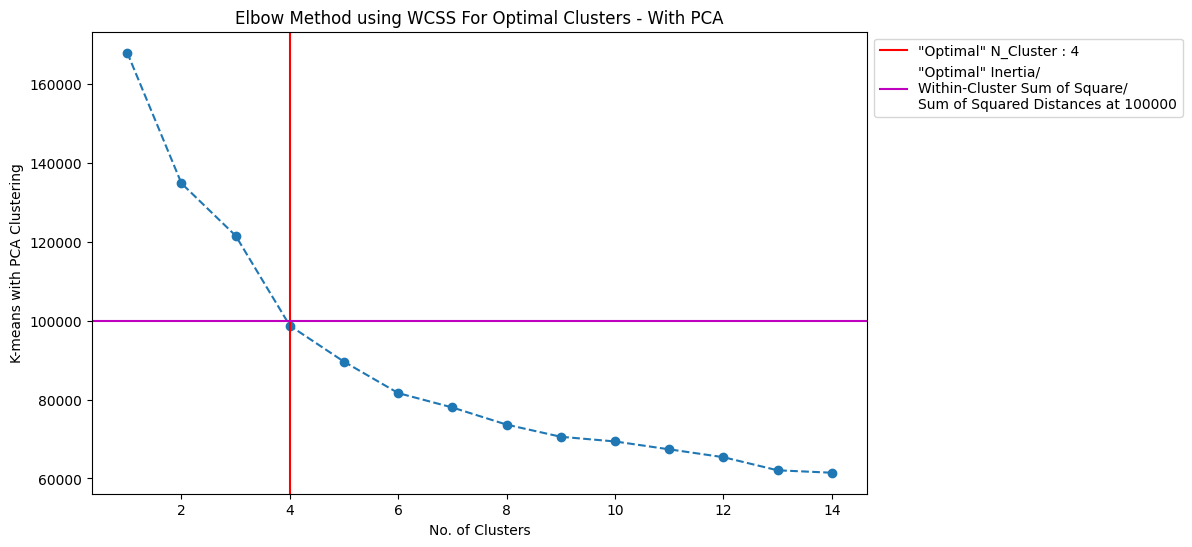

In [49]:
plt.figure(figsize= (10,6))
plt.plot(range(1, len(X.columns)), wcss, marker ='o', linestyle = '--')
plt.title('Elbow Method using WCSS For Optimal Clusters - With PCA')
plt.xlabel('No. of Clusters')
plt.ylabel('K-means with PCA Clustering')
plt.axvline(x = 4, color = 'r', label = '"Optimal" N_Cluster : 4')
plt.axhline(y = 100000, color = 'm', label = '"Optimal" Inertia/\nWithin-Cluster Sum of Square/\nSum of Squared Distances at 100000')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2521765878680166
For n_clusters = 3 The average silhouette_score is : 0.20942275732956617
For n_clusters = 4 The average silhouette_score is : 0.2220100243247877
For n_clusters = 5 The average silhouette_score is : 0.21331103746770716
For n_clusters = 6 The average silhouette_score is : 0.22188702943531746
For n_clusters = 7 The average silhouette_score is : 0.19281361387838566
For n_clusters = 8 The average silhouette_score is : 0.2059115779786075
For n_clusters = 9 The average silhouette_score is : 0.1910322345502362
For n_clusters = 10 The average silhouette_score is : 0.18804963995695212
For n_clusters = 11 The average silhouette_score is : 0.18953010121875097
For n_clusters = 12 The average silhouette_score is : 0.1731273413454899
For n_clusters = 13 The average silhouette_score is : 0.1882769480872419
For n_clusters = 14 The average silhouette_score is : 0.17503667509663595
For n_clusters = 15 The average silhouette_score is 

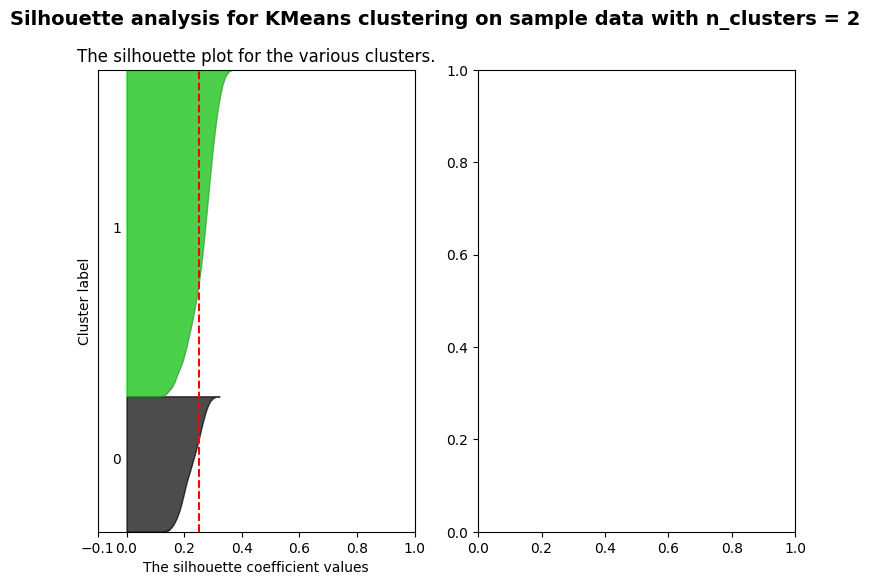

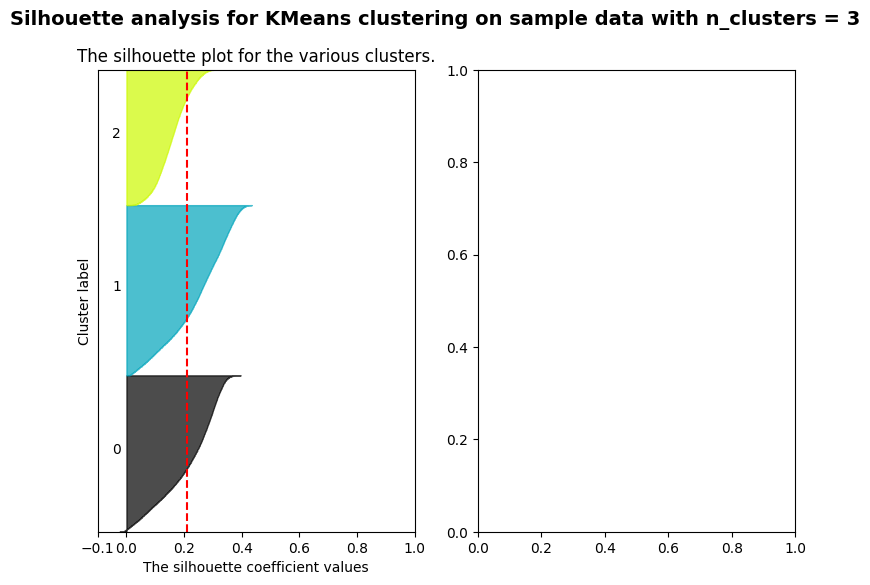

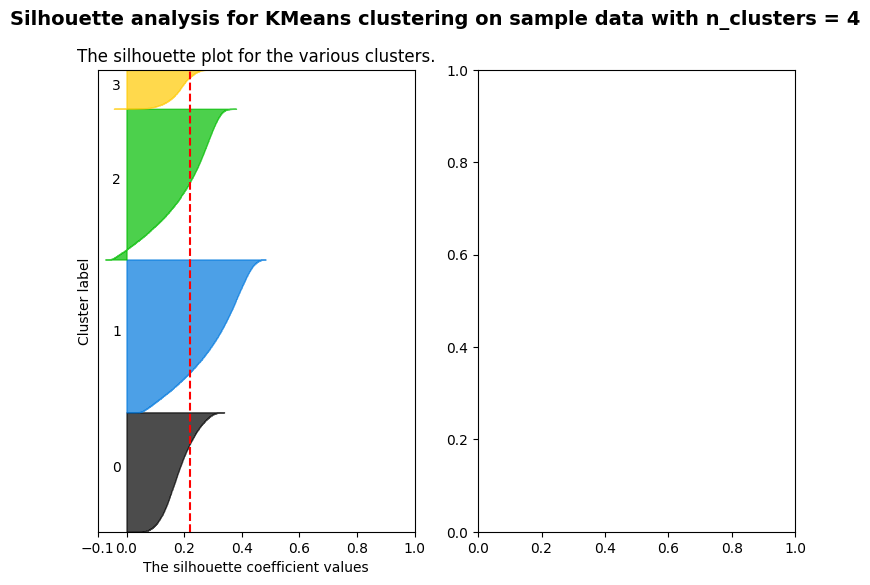

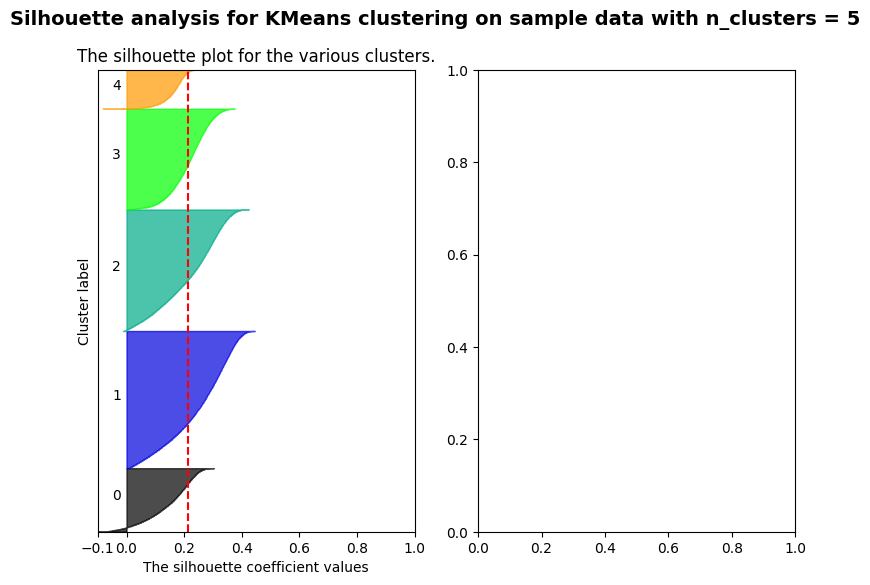

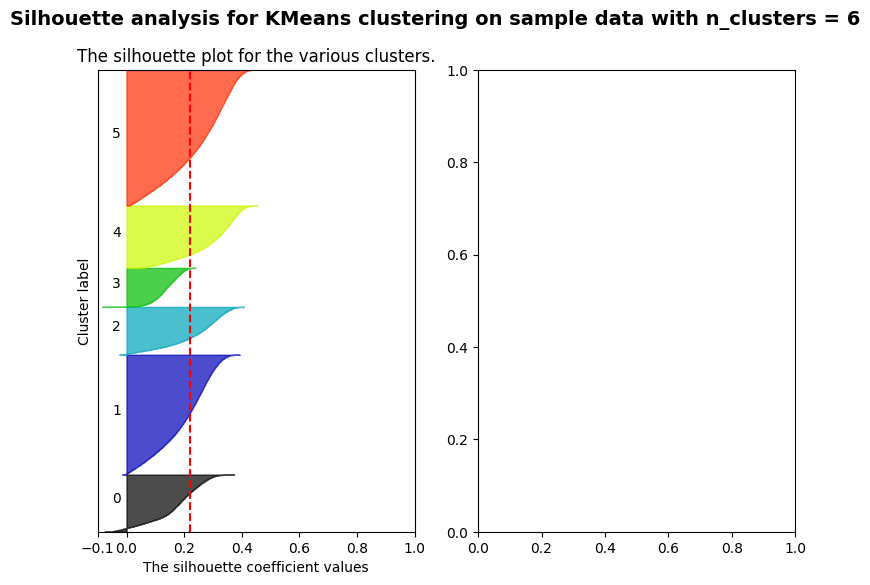

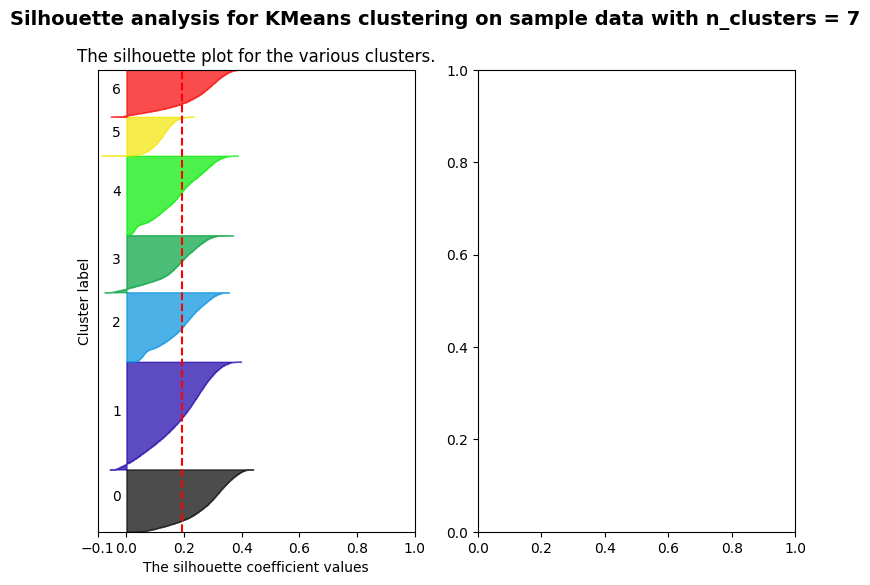

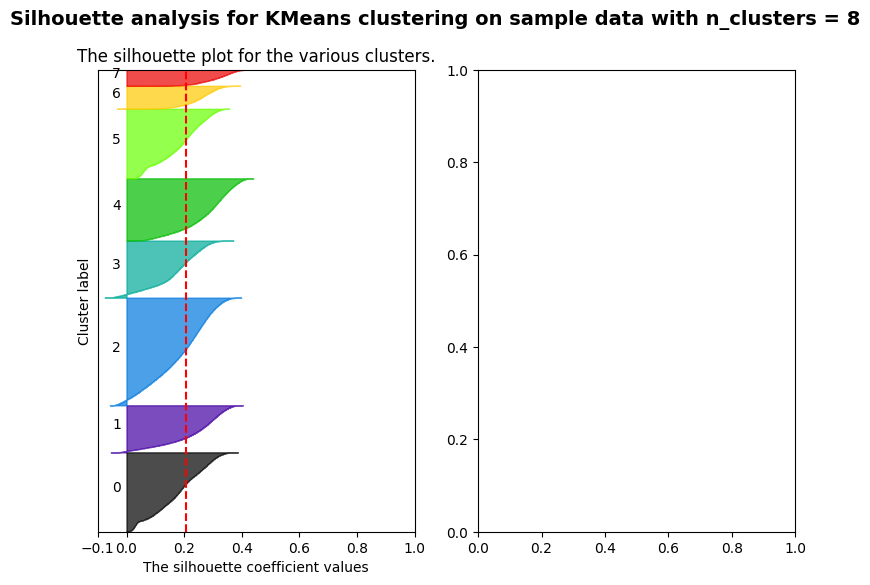

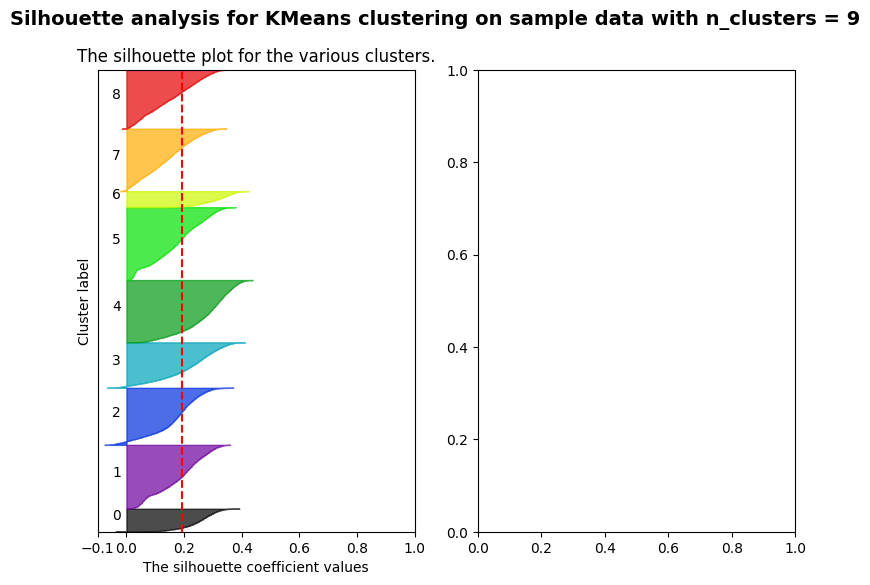

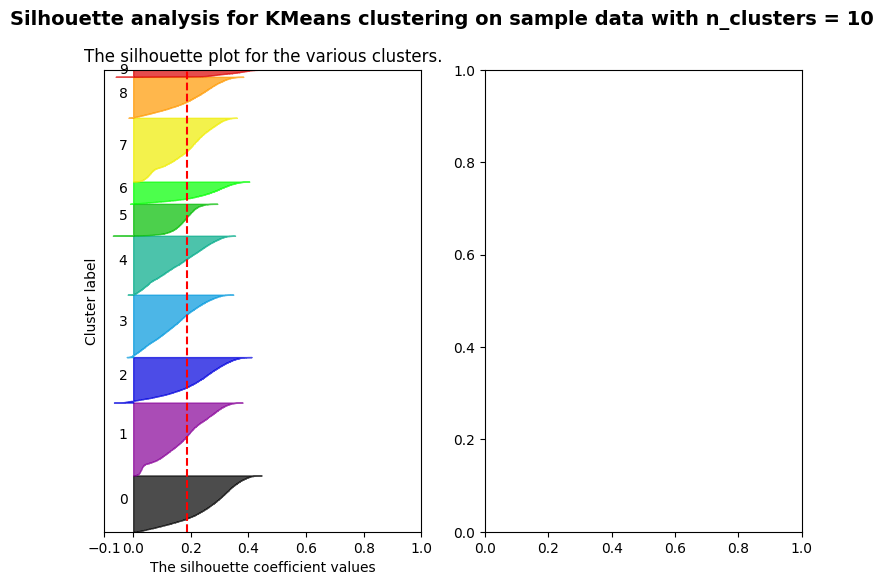

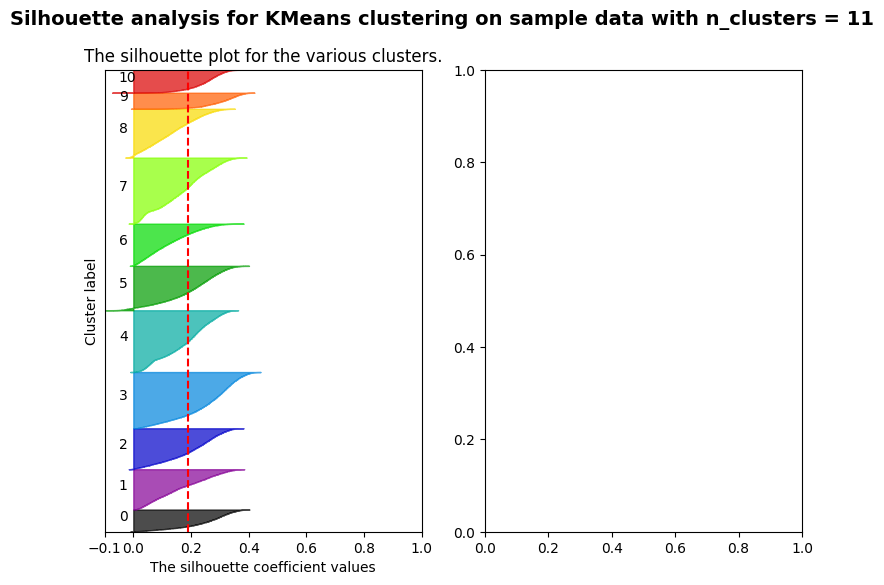

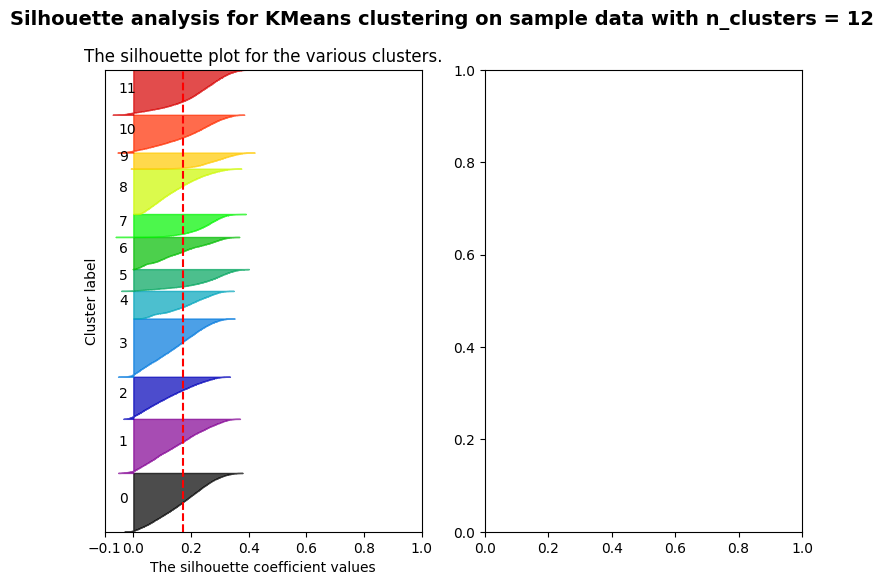

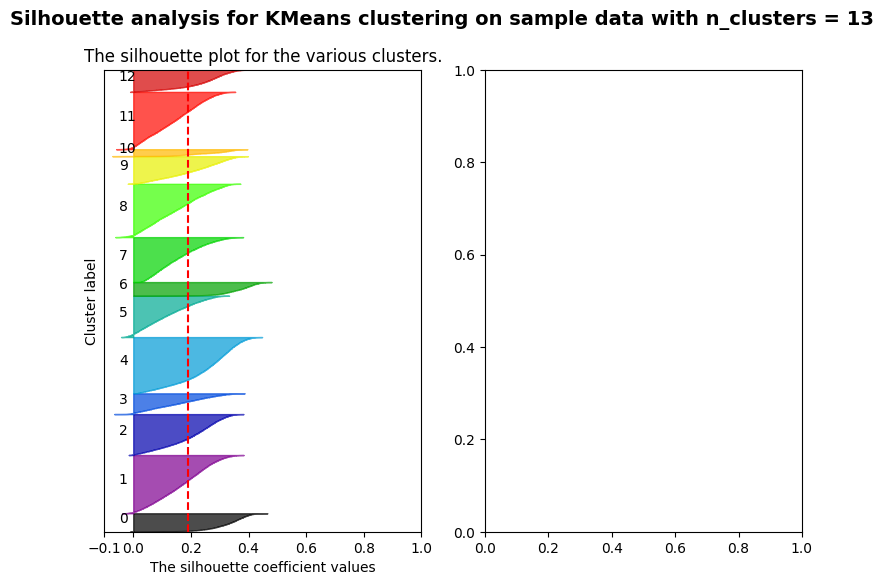

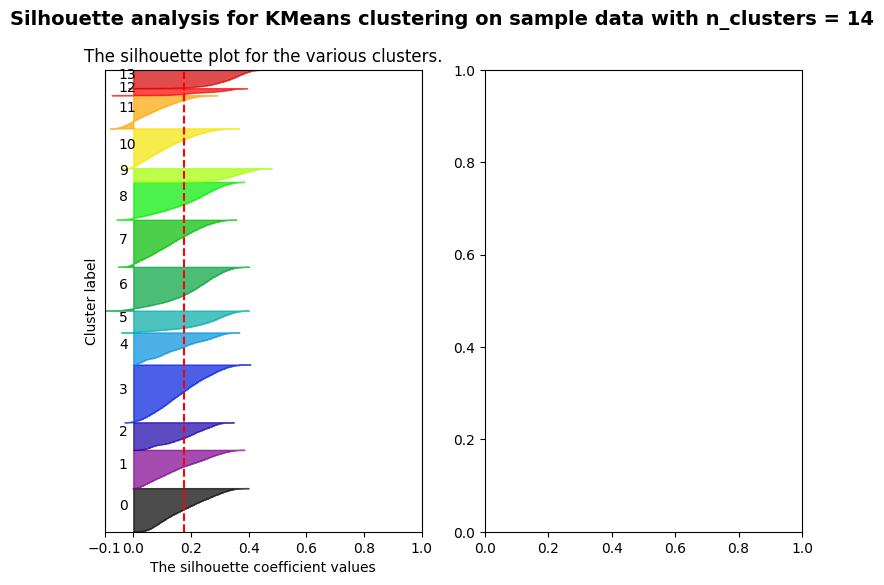

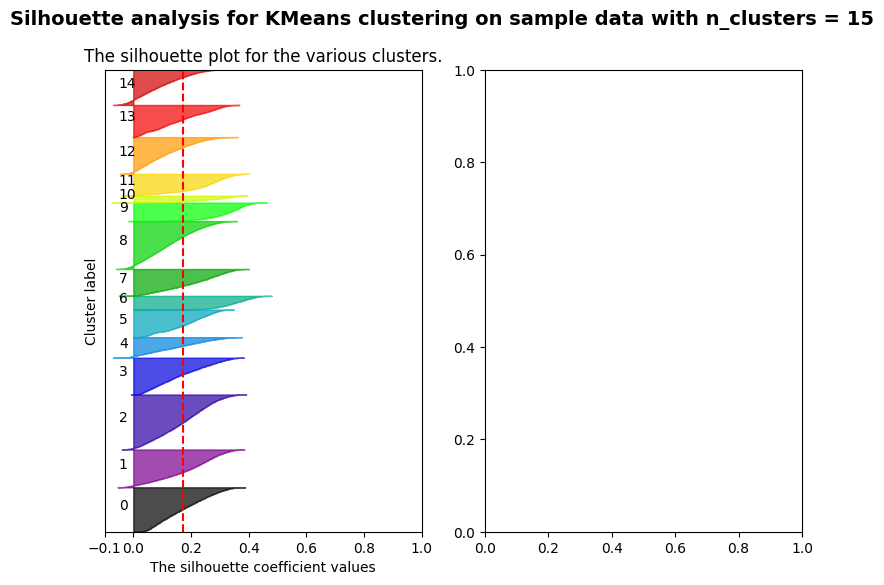

In [61]:
silhouette_analysis_data = {'no_clusters' : [], 'silhouette_average_score' : [], 'silhouette_samples_values' : [], 'cluster_labels' : [], 'KMeans_labels' : [], 'centers' : [], 'silhouette_coefficients' : []}    
silhouette_coefficients = []

for n_clusters in np.arange(2, len(X.columns)+1, step=1):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans_kwargs= {
    'init':'k-means++',
    'n_init':10,
    'max_iter':300,
    'random_state':42}

    kmeans_sil = KMeans(n_clusters=n_clusters,**kmeans_kwargs)
    cluster_labels = kmeans_sil.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_average_score = silhouette_score(X, cluster_labels)
    sil_score = silhouette_score(X, kmeans_sil.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_average_score,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_average_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # ax2.scatter(pca_scores[:, 0], pca_scores[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = kmeans_sil.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    plt.savefig(f'sil_analysis_clusters{n_clusters}.png')
    silhouette_analysis_data['no_clusters'].append(n_clusters)
    silhouette_analysis_data['silhouette_average_score'].append(silhouette_average_score)
    silhouette_analysis_data['silhouette_samples_values'].append(sample_silhouette_values)
    silhouette_analysis_data['cluster_labels'].append(cluster_labels)
    silhouette_analysis_data['KMeans_labels'].append(kmeans_sil.labels_)
    silhouette_analysis_data['centers'].append(centers)
    silhouette_analysis_data['silhouette_coefficients'].append(sil_score)
    silhouette_coefficients.append(sil_score)

   
# plt.show()
# plt.savefig(f'sil_analysis_clusters{n_clusters}.png')

In [ ]:
silhouette_coefficients = []
# silhouette_analysis_data = {'no_clusters' : [], 'silhouette_average_score' : [], 'silhouette_samples_values' : [], 'cluster_labels' : [], 'centers' : []}
# sil_limit = int(limit/4)
# print(f'Revised_limit for Silhouette Analysis : {sil_limit}')

kmeans_kwargs= {
    'init':'random',
    'n_init':10,
    'max_iter':300,
    'random_state':42}
# kmeans_sil = KMeans(n_clusters=k, **kmeans_kwargs)
# kmeans_sil.fit(pca_scores)
# sil_score = silhouette_score(X, kmeans_sil.labels_)
# silhouette_coefficients.append(sil_score)

for k in range(2, len(X.columns)+1):
    kmeans_sil = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_sil.fit(X)
    sil_score = silhouette_score(X, kmeans_sil.labels_)
    # sil_score = silhouette_score(X, kmeans_sil.labels_)
    silhouette_coefficients.append(sil_score)
    # sil_sample_values = silhouette_samples(X, kmeans_sil.labels_)
    # silhouette_analysis_data['no_clusters'].append(k)
    # silhouette_analysis_data['silhouette_average_score'].append(sil_score)
    # silhouette_analysis_data['silhouette_samples_values'].append(sil_sample_values)
    # silhouette_analysis_data['cluster_labels'].append(kmeans_sil.labels_)
    # silhouette_analysis_data['centers'].append(kmeans_sil.cluster_centers_)
    print(f'Completed n_clusters : {k} | Silhouette_score : {sil_score}')

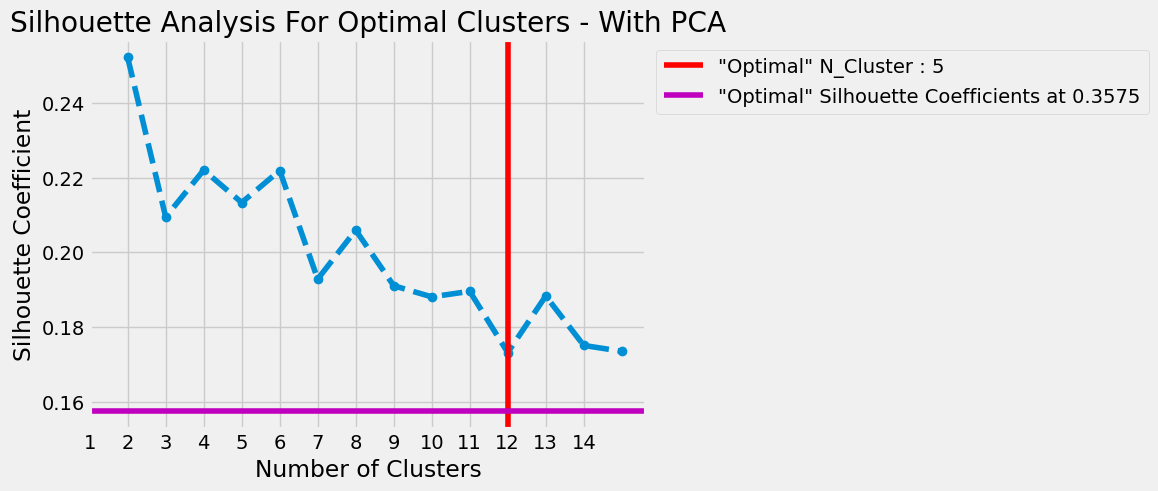

In [63]:
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(2,len(X.columns)+1 ), silhouette_coefficients, marker ='o', linestyle = '--')
plt.xticks(range(1, len(X.columns)))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Analysis For Optimal Clusters - With PCA')
plt.axvline(x = 12, color = 'r', label = '"Optimal" N_Cluster : 5')
plt.axhline(y = 0.1575, color = 'm', label = '"Optimal" Silhouette Coefficients at 0.3575')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

# Importing the KMeans clustering algorithm that is used to generate clusters from music relations

Use Elbow Analysis = 4 but Sihouette = 12 shows the best chart

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       170653 non-null  float64
 1   explicit          170653 non-null  float64
 2   popularity        170653 non-null  float64
 3   danceability      170653 non-null  float64
 4   energy            170653 non-null  float64
 5   key               170653 non-null  float64
 6   loudness          170653 non-null  float64
 7   mode              170653 non-null  float64
 8   speechiness       170653 non-null  float64
 9   acousticness      170653 non-null  float64
 10  instrumentalness  170653 non-null  float64
 11  liveness          170653 non-null  float64
 12  valence           170653 non-null  float64
 13  tempo             170653 non-null  float64
 14  genres_encoded    170653 non-null  float64
dtypes: float64(15)
memory usage: 19.5 MB


In [64]:
kmeans = KMeans(n_clusters=12, init='k-means++', random_state=42)
kmeans.fit_transform(X)
# kmeans_pca.fit_transform(pca_scores)

array([[1.96143833, 1.75158887, 1.41633645, ..., 0.81442437, 1.98649608,
        1.38509831],
       [1.59804336, 1.14303408, 1.23196987, ..., 1.07202292, 1.6408689 ,
        0.49766083],
       [2.03106104, 1.70763399, 0.71589323, ..., 1.1877241 , 1.85610989,
        1.30437849],
       ...,
       [0.53707947, 1.10761737, 1.76317749, ..., 1.7359248 , 1.25219662,
        1.26457056],
       [1.48743316, 1.14529245, 1.63794205, ..., 1.21852853, 1.96302484,
        1.41202525],
       [1.93494251, 1.70541297, 1.44827363, ..., 0.70646852, 2.08027677,
        1.357057  ]])

In [65]:
track_data['segment']= kmeans.labels_
dic_cluster = {i:f'cluster_{i+1}' for i in range(kmeans.n_clusters)}
track_data['Segments_KMeans_PCA']=track_data['segment'].map(dic_cluster)
track_data.head()

,id,song,artists,genres,year,duration_ms,explicit,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres_encoded,segment,Segments_KMeans_PCA
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","Sergei Rachmaninoff, James Levine, Berliner Ph...",ukrainian classical,1921,831667,0,4,0.279,0.211,...,1,0.0366,0.982,0.878,0.665,0.0594,80.954,1670.0,9,cluster_10
1,5uNZnElqOS3W4fRmRYPk4T,The Wearing of the Green,John McCormack,vintage classical singing,1921,159507,0,4,0.518,0.203,...,1,0.0615,0.996,0.000,0.115,0.4060,66.221,1707.0,11,cluster_12
2,02GDntOXexBFUvSgaXLPkd,"Morceaux de fantaisie, Op. 3: No. 2, Prélude i...",Sergei Rachmaninoff,ukrainian classical,1921,218773,0,2,0.389,0.088,...,0,0.0456,0.993,0.527,0.363,0.0731,92.867,1670.0,2,cluster_3
3,05xDjWH9ub67nJJk82yfGf,La Mañanita - Remasterizado,Ignacio Corsini,tango,1921,161520,0,0,0.485,0.130,...,0,0.0483,0.996,0.151,0.104,0.7210,64.678,1576.0,2,cluster_3
4,08zfJvRLp7pjAb94MA9JmF,Il Etait Syndiqué,Fortugé,vintage chanson,1921,196560,0,0,0.684,0.257,...,1,0.3990,0.982,0.000,0.504,0.7710,109.378,1705.0,8,cluster_9


In [66]:
track_data.to_pickle('track_data_KMeansNearestNeighbors.pkl')
track_data.to_csv('track_data_KMeansNearestNeighbors.csv', index=False)

# Creating a recommendation machine

In [55]:
def get_track_data():

    track_data =pd.read_pickle('track_data_KMeansNearestNeighbors.pkl')
    return track_data


def get_features_info():
    INPUT_FEATURES = ['id','song', 'artists', 'genres', 'year', 'duration_ms', 'explicit', 'popularity', 'danceability',
                'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'segment']
    
    TRAIN_FEATURES = ['duration_ms', 'explicit', 'popularity', 'danceability',
            'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']

    TRACK_SUMMARY = ['id','song', 'artists', 'genres', 'year', 'segment']

    return INPUT_FEATURES,TRAIN_FEATURES, TRACK_SUMMARY


def get_track_info(track_data, selected_song_index):
    
    track_info = track_data[['id','song','artists','genres','year']].iloc[selected_song_index]
    
    return track_info


def get_neighbors_by_segment(selected_songs_by_segment, selected_song_input, no_neighbors=10):
    from sklearn.neighbors import NearestNeighbors
        
    nneigh = NearestNeighbors(n_jobs=-1, leaf_size=30, metric='manhattan', algorithm = 'kd_tree', p=1, radius=1.6)
    nneigh.fit(X=selected_songs_by_segment)
    distances, indices_kneighbors =  nneigh.kneighbors(X=selected_song_input,n_neighbors=no_neighbors,return_distance=True)

    indices_kneighbors = indices_kneighbors.tolist()[0]
    indices = []
    for i in indices_kneighbors:
        indices.append(selected_songs_by_segment.index[i])
    
    return distances.tolist()[0], indices


def get_neighbors_by_trained_model(trained_model, selected_song_input, no_neighbors=10):
        
    distances, indices = trained_model.kneighbors(selected_song_input, n_neighbors=no_neighbors)
    
    return distances.tolist()[0], indices.tolist()[0]


def song_recommender(track_data, user_input=None,no_neighbors=10):
    from thefuzz import fuzz
    from thefuzz import process

    INPUT_FEATURES, TRAIN_FEATURES, TRACK_SUMMARY = get_features_info()
    select_song_index= process.extractOne(user_input, track_data.song)[2]
    select_song_segment = track_data.segment.iloc[select_song_index]
    selected_song_input = track_data[TRAIN_FEATURES].iloc[select_song_index].values.reshape(1,-1)
    selected_songs_by_segment = track_data[TRAIN_FEATURES].loc[track_data.segment == select_song_segment]
    distances, indices = get_neighbors_by_segment(selected_songs_by_segment,selected_song_input,no_neighbors*5)
    
    return distances, indices


def get_recommended_songs(indices):
    recommend_songs_list = {'song_name': [],
                        'song_artists': [],
                        'song_genres': [],
                        'song_year':[],
                        'song_id': []}
    for idx in indices:
        track_info = get_track_info(track_data=track_data, selected_song_index=idx)
        recommend_songs_list['song_id'].append(track_info['id'])
        recommend_songs_list['song_name'].append(track_info['song'])
        recommend_songs_list['song_artists'].append(track_info['artists'])
        recommend_songs_list['song_genres'].append(track_info['genres'])
        recommend_songs_list['song_year'].append(track_info['year'])

    recommend_songs = pd.DataFrame(recommend_songs_list)

    return recommend_songs



In [67]:
from thefuzz import fuzz
from thefuzz import process
# user_input = 'horn sonata'
user_input = 'bad medicine'
no_neighbors = 50


distances, indices = song_recommender(track_data=track_data, 
                            user_input=user_input,
                            no_neighbors=no_neighbors
                            )
recommend_songs = get_recommended_songs(indices)
recommend_songs.sort_index()


,song_name,song_artists,song_genres,song_year,song_id
0,Bad Medicine,Bon Jovi,rock,1988,72hcFp4tYkd3dbNA9dZ3Pv
1,You've Got to Hurt Before You Heal,Bobby Blue Bland,southern soul,1989,3MaKNi2ldUSySJyHus0DWg
2,Cry in the Wind,Clan of Xymox,new romantic,1985,6gCYI9V22qxOKgGnLfTZqy
3,Vogue,Madonna,dance pop,2009,27QvYgBk0CHOVHthWnkuWt
4,I Try,Will Downing,quiet storm,1991,1XOQGOEW2SrJAmoFwSR6ov
...,...,...,...,...,...
245,Catching Fireflies,The Revivalists,rock,2010,4daxThR2Ny2xj0hkar6XkX
246,One Of Us,Joan Osborne,new wave pop,1995,1xNmF1Uep5OGutizZSbKvd
247,Encore,"Eminem, Dr. Dre, 50 Cent",west coast rap,2004,5lWOdnLsibUnGLcxhz1mri
248,Dead Skin Mask,Slayer,rock,1990,0t1lDXmMWBzF6mfnQ6KwqZ


In [68]:
recommend_songs.sample(n=25)

,song_name,song_artists,song_genres,song_year,song_id
204,I and I Survive,Bad Brains,ska punk,1983,4tMlyDh4A8cttW6jFBTRmv
69,El Hombre del Piano,Ana Belén,nueva cancion,1979,61ccRl3FBtLs3U5HuBtP6e
4,I Try,Will Downing,quiet storm,1991,1XOQGOEW2SrJAmoFwSR6ov
52,Tupelo Honey,"Wayne Toups, Zydecajun",zydeco,1989,4eAhcwVAUIsautuiO6RGOO
144,Man Of Sorrows - Live,Hillsong Worship,worship,2013,7tURQQhMTcJXIVe1dvji7v
14,Time - Live,Pink Floyd,rock,1988,1ibpQFoKoawNqgJaXaVR3k
175,Man in the Mirror,Michael Jackson,soul,1995,2u2udGmop1z67EPpr91km7
146,Born On The Bayou - Live,Creedence Clearwater Revival,swamp rock,1980,3PLnH5T3MB9ItFADOxSp83
114,Drugs - 2005 Remaster,Talking Heads,zolo,1979,0OnQj8a27DzuNnTXSgOtq6
187,Sognare,División Minúscula,latin alternative,2006,3EYPZf5gtyU9suVqTWChzk
